# Predicting stock seasonality using TimeSeries Forecasting 

#### This notebook covers the usage of various time series forecasting methods for predicting the stock seasonality and hence the best time of the year to invest in that stock

Based on the analysis of stock data and results of cross-validation following methods have been shortlisted:<br>
<ul>
<li>Seasonal decompose based seasonality forecasting: statsmodels, pmdarima
    <ol>
        <li>statsmodels - Seasonality:additive/multiplicative</li>
        <li>pmdarima - Seasonality:additive/multiplicative</li>
    </ol>
</li>
<li>Timeseries algorithms for seasonality forecasting: 
    <ol>
        <li>Holt-Winters - Trend:None/additive/multiplicative, Seasonality:additive/multiplicative </li>
        <li>Auto-ARIMA - Fourier featurizer to handle seasonality, with and without other exogenous features</li>
    </ol>
</li>
<li>Facebook Prophet for timeseries forecasting: 
    <ol>
        <li>Prediction based: Seasonality: yearly, Mode: additive/multiplicative, Growth:Linear/Logistic</li>
        <li>Seasonality based: Seasonality: yearly, Mode: additive/multiplicative, Growth:Linear/Logistic</li>
    </ol>
</li>
</ul>

In [1]:
import time
start = time.time()

In [2]:
#Import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime 

#Statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES

#PMD Arima
import pmdarima as pm
#print(f"Using pmdarima {pm.__version__}")

#FB Prophet
from fbprophet import Prophet

#Prediction Accuracy Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
from numpy import *

%matplotlib inline
#pd.options.display.float_format = "{:,.4f}".format
pd.options.display.precision = 6
import warnings
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


In [3]:
#Initialize the common variables
source_dir =  r'..\data\rawdata' + '\\'
transformed_dir =  r'..\data\inputdata' + '\\'
sma_rolling_window = 5 #Rolling window for simple moving average of stock price
eda_window = 5 #7 #Rolling window for stationarity analysis
min_train_data_years = 5
min_cross_val = 3
max_cross_val = 5
min_years_data_reqd = min_train_data_years + min_cross_val
current_year = datetime.datetime.now().year
stock_tickers = ['BLUESTARCO'] #['VOLTAS', 'TWL', 'ESCORTS', 'MARUTI']
cnt_stocks = len(stock_tickers)
print('No. of stocks analysed:', cnt_stocks)
stock_ticker = stock_tickers[0]
print('Selected stock: ' + stock_ticker)

No. of stocks analysed: 1
Selected stock: BLUESTARCO


### Load the stock data

In [4]:
group_by_col = 'year'
agg_value_col = 'adj_close'
agg_value_col_sma = 'sma'
wd_col = 'work_doy'
pctile_col = 'pctile'

In [5]:
def load_data(file_path):
    #Select required columns from csv
    #rawdata = pd.read_csv(file_path, index_col=0, usecols=['Date', 'Adj Close'], parse_dates=True)
    rawdata = None
    rawdata = pd.read_csv(file_path, index_col=0, parse_dates=True)
    rawdata = rawdata.dropna(how = 'any') ##Drop rows with empty cells
    rawdata.index.names = ['date']
    rawdata.rename(columns={"Adj Close": "adj_close"}, inplace = True)
    rawdata.sort_index(ascending = True, inplace = True)
    #Sort data by date
    return rawdata.copy()

In [6]:
data = load_data(source_dir + stock_ticker + '.csv')
#years_of_data = len(data.index.year.unique()) - 1 ##-1 for removing current year
data.head()

,High,Low,Open,Close,Volume,adj_close
date,,,,,,
2002-07-01,14.00,13.20,14.00,13.26,28220.0,3.985216
2002-07-02,13.58,13.13,13.58,13.19,32725.0,3.964178
2002-07-03,13.78,13.20,13.78,13.39,20810.0,4.024287
2002-07-04,13.58,13.32,13.45,13.45,16990.0,4.042319
2002-07-05,13.60,13.30,13.40,13.44,23525.0,4.039313


### Transform data 
Add additional columns, remove current year data

<b>Note:</b> We are using a 5 day simple moving average(SMA) as an indicator of time frame for investment rather than a single day's close value. 
<br>Reasons:
<br>There could be multiple days with the same min. value spread across different time frames. Hence, it makes sense to use a simple moving average rather than individual close value.
<br>Also, this will avoid impact of any sudden surges/spikes in the analysis.

In [7]:
def transform_data(rawdf):
    #Simple moving average of adjusted close price with 2 prior and 2 next values
    rawdf['sma'] = rawdf.adj_close.rolling(window=sma_rolling_window, min_periods=1).mean().shift(-2)
    rawdf['year'] = rawdf.index.year
    #Drop current year's records from analysis
    rawdf = rawdf[rawdf.year < current_year] 
    rawdf["month"] = rawdf.index.month
    rawdf['week'] = pd.Int64Index(rawdf.index.isocalendar().week) #Deprecated - rawdf.index.week/weekofyear
    rawdf["day_of_week"] = rawdf.index.dayofweek
    rawdf["day_of_month"] = rawdf.index.day
    #Store day of year
    rawdf['day_of_year'] = rawdf.index.dayofyear
    #Add row count by year to get working day of year, this is column used for align prediction output
    rawdf[wd_col] = rawdf.groupby(['year']).cumcount() + 1
    #Add percentile using rank, this is column used for determining the accuracy of prediction
    rawdf[pctile_col] = 100 * rawdf.groupby("year")["sma"].rank("min", pct=True, ascending=True)    
    #Handle ISO week format for last days of year marked as Week 1
    rawdf.loc[(rawdf['week'] == 1) & (rawdf['day_of_year'] > 350),'week'] = 53 
    return rawdf.copy()

In [8]:
data = transform_data(data.copy())
data.tail(5)

,High,Low,Open,Close,Volume,adj_close,sma,year,month,week,day_of_week,day_of_month,day_of_year,work_doy,pctile
date,,,,,,,,,,,,,,,
2019-12-24,795.450012,783.000000,792.000000,784.950012,24874.0,772.610962,782.296289,2019,12,52,1,24,358,238,78.099174
2019-12-26,793.000000,781.000000,785.000000,791.299988,42287.0,778.861145,782.148645,2019,12,52,3,26,360,239,77.272727
2019-12-27,805.500000,788.299988,795.000000,801.500000,43755.0,788.900818,792.227661,2019,12,52,4,27,361,240,91.735537
2019-12-30,809.500000,795.549988,804.900024,805.799988,23512.0,793.133179,800.879492,2019,12,53,0,30,364,241,95.454545
2019-12-31,859.849976,797.400024,804.900024,840.849976,103435.0,827.632202,804.541016,2019,12,53,1,31,365,242,95.867769


In [9]:
data.describe()

,High,Low,Open,Close,Volume,adj_close,sma,year,month,week,day_of_week,day_of_month,day_of_year,work_doy,pctile
count,4316.000000,4316.000000,4316.000000,4316.000000,4.316000e+03,4316.000000,4316.000000,4316.000000,4316.000000,4316.000000,4316.000000,4316.000000,4316.000000,4316.000000,4316.000000
mean,312.056798,300.516835,306.373026,305.929470,5.126757e+04,278.373669,278.372768,2010.712002,6.589666,27.069045,1.991891,15.784986,185.193930,122.025023,50.200166
std,228.374945,220.932624,224.835333,224.468514,9.329197e+04,220.867256,220.776195,5.064017,3.432997,14.996109,1.413125,8.776040,104.940275,71.173734,28.871369
min,13.200000,12.800000,12.840000,13.190000,0.000000e+00,3.964178,3.975598,2002.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.396825
25%,141.600006,136.687496,139.275002,139.357502,1.341300e+04,114.133831,114.828433,2006.000000,4.000000,14.000000,1.000000,8.000000,95.000000,60.000000,25.203252
50%,302.000000,290.000000,295.000000,295.300003,2.667100e+04,256.922440,256.337469,2011.000000,7.000000,27.000000,2.000000,16.000000,187.000000,120.000000,50.000000
75%,438.324989,425.000000,432.000000,431.950012,5.236550e+04,378.097054,377.922551,2015.000000,10.000000,40.000000,3.000000,23.000000,274.000000,184.000000,75.203252
max,882.450012,854.000000,873.849976,866.700012,2.883470e+06,853.075867,836.254529,2019.000000,12.000000,53.000000,4.000000,31.000000,366.000000,252.000000,100.000000


In [10]:
wd_series = data[wd_col]
pctile_series = data[pctile_col]

### Aggregate Data
Derive important yearly metrics

In [11]:
#def agg_data(records):
def agg_data():
    #Aggregate data on yearly basis - Min. day of year will be our output
    year_agg_data = None
    year_agg_data = pd.concat([data.groupby(group_by_col)[agg_value_col].count().rename('record_cnt')
                          , data.groupby(group_by_col)[agg_value_col].mean().rename('mean_' + agg_value_col)
                          , data.groupby(group_by_col)[agg_value_col].min().rename('min_' + agg_value_col)
                          , data.groupby(group_by_col)[agg_value_col_sma].min().rename('min_' + agg_value_col_sma)
                          , data.groupby(group_by_col)[agg_value_col].idxmin().rename('date_min_' + agg_value_col)
                          , data.groupby(group_by_col)[agg_value_col_sma].idxmin().rename('date_min_' + agg_value_col_sma)
                          , data.groupby(group_by_col)[agg_value_col].idxmin().dt.dayofyear.rename('doy_min_' + agg_value_col)
                          , data.groupby(group_by_col)[agg_value_col_sma].idxmin().dt.dayofyear.rename('doy_min_' + agg_value_col_sma)
                          #, data.groupby(group_by_col)[agg_value_col].max().rename('max_' + agg_value_col)
                          #, data.groupby(group_by_col)[agg_value_col].median().rename('median_' + agg_value_col)
                          ], axis=1)
    ## Remove rows for years when the adj_close has -ve values
    year_agg_data = year_agg_data[year_agg_data.min_adj_close > 0]
    
    ##Get working day of min. price
    #wd_min_price = data.loc[data.groupby(group_by_col)[agg_value_col].idxmin()][[group_by_col, wd_col]].set_index([group_by_col])
    #wd_min_price.rename(columns={wd_col: 'wd_min_'+agg_value_col}, inplace = True)
    #wd_min_sma = data.loc[data.groupby(group_by_col)[agg_value_col_sma].idxmin()][[group_by_col, wd_col]].set_index([group_by_col])
    #wd_min_sma.rename(columns={wd_col: 'wd_min_'+agg_value_col_sma}, inplace = True)
    #year_agg_data = year_agg_data.join(wd_min_price).join(wd_min_sma) 
    year_agg_data['wd_min_'+agg_value_col] = year_agg_data.apply(lambda row: wd_series[row.date_min_adj_close], axis=1)
    year_agg_data['wd_min_'+agg_value_col_sma] = year_agg_data.apply(lambda row: wd_series[row.date_min_sma], axis=1)
    
    ## Check diff. between min. price working day based on actual value and moving avg.
    year_agg_data['target_doy_diff'] = abs(year_agg_data.doy_min_adj_close - year_agg_data.doy_min_sma)
    year_agg_data['target_wd_diff'] = abs(year_agg_data.wd_min_adj_close - year_agg_data.wd_min_sma)
    #return year_agg_data.copy()
    return year_agg_data

In [12]:
#year_agg_data = agg_data(data.copy())
year_agg_data = agg_data()
year_agg_data

,record_cnt,mean_adj_close,min_adj_close,min_sma,date_min_adj_close,date_min_sma,doy_min_adj_close,doy_min_sma,wd_min_adj_close,wd_min_sma,target_doy_diff,target_wd_diff
year,,,,,,,,,,,,
2002,125,4.119090,3.964178,3.975598,2002-07-02,2002-09-24,183,267,2,60,84,58
2003,251,8.112309,4.345869,4.368109,2003-02-10,2003-02-06,41,37,29,27,4,2
2004,252,20.463309,12.454689,12.625892,2004-03-26,2004-03-25,86,85,59,58,1,1
2005,248,47.654275,30.742998,31.321084,2005-03-30,2005-04-01,89,91,60,62,2,2
2006,247,106.600037,73.618057,74.675687,2006-06-07,2006-01-16,158,16,105,10,142,95
2007,248,235.158608,155.413162,156.270917,2007-01-02,2007-01-02,2,2,1,1,0,0
2008,246,302.496989,106.380028,109.688313,2008-12-05,2008-12-08,340,343,230,231,3,1
2009,238,232.472123,110.852966,112.659021,2009-02-10,2009-02-10,41,41,26,26,0,0
2010,250,364.126506,303.199982,304.958417,2010-03-04,2010-03-04,63,63,41,41,0,0


As indicated in the above dataframe, in most year's the date of min. adjusted close price is within a week of the date of min. adjusted simple moving avg. of close price. However, for some years, the value is very far. Hence, it is proven that it makes sense to use SMA

In [13]:
#Remove years when Adjusted close < 0
data = data[data.year >= year_agg_data.index.min()] 
data.head() 

,High,Low,Open,Close,Volume,adj_close,sma,year,month,week,day_of_week,day_of_month,day_of_year,work_doy,pctile
date,,,,,,,,,,,,,,,
2002-07-01,14.00,13.20,14.00,13.26,28220.0,3.985216,3.991227,2002,7,27,0,1,182,1,5.6
2002-07-02,13.58,13.13,13.58,13.19,32725.0,3.964178,4.004000,2002,7,27,1,2,183,2,8.0
2002-07-03,13.78,13.20,13.78,13.39,20810.0,4.024287,4.011063,2002,7,27,2,3,184,3,8.8
2002-07-04,13.58,13.32,13.45,13.45,16990.0,4.042319,4.063357,2002,7,27,3,4,185,4,28.8
2002-07-05,13.60,13.30,13.40,13.44,23525.0,4.039313,4.134887,2002,7,27,4,5,186,5,74.4


In [14]:
year_agg_data.index.values

array([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019], dtype=int64)

##### Validate if sufficient data is available for forecasting

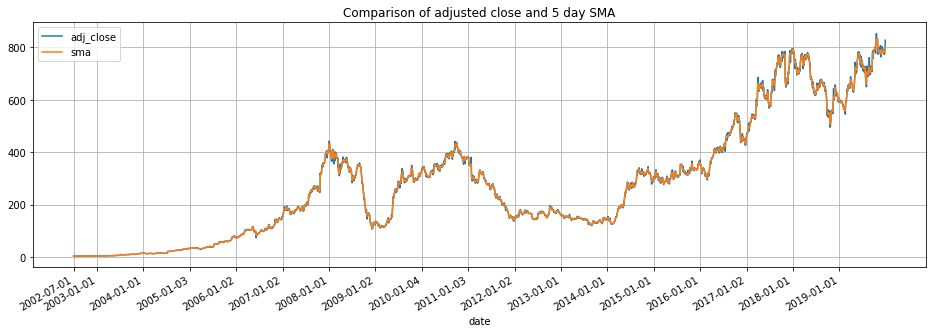

In [15]:
data[['adj_close', 'sma']].plot(figsize=(16,5), grid=True, xticks = data.groupby(group_by_col)[wd_col].idxmin())
plt.title('Comparison of adjusted close and 5 day SMA');

Text(0.5, 1.0, 'Adjusted close price perecentile values grouped on yearly basis')

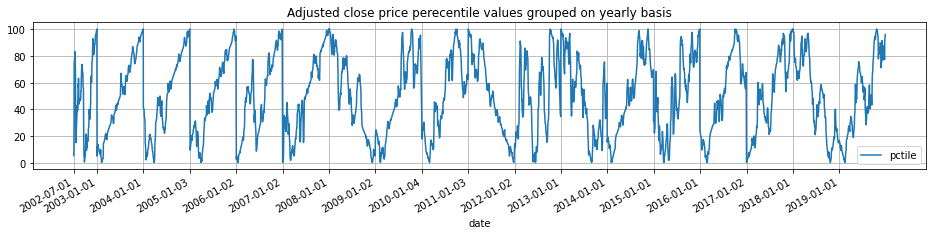

In [16]:
data[[pctile_col]].plot(figsize=(16,3), grid=True, xticks = data.groupby(group_by_col)[wd_col].idxmin())
plt.title('Adjusted close price perecentile values grouped on yearly basis')

In [17]:
years_of_data = len(year_agg_data) #len(data.index.year.unique())
print("Minimum", min_years_data_reqd, "years of historical data required for forecasting")  
print("Historical stocks data for", stock_ticker , "is available for", years_of_data, "years")
# Check min. years of data required for forecasting
if (years_of_data < min_years_data_reqd):    
    print("Historical stocks data for", stock_ticker, "is not sufficient for forecasting")

Minimum 8 years of historical data required for forecasting
Historical stocks data for BLUESTARCO is available for 18 years


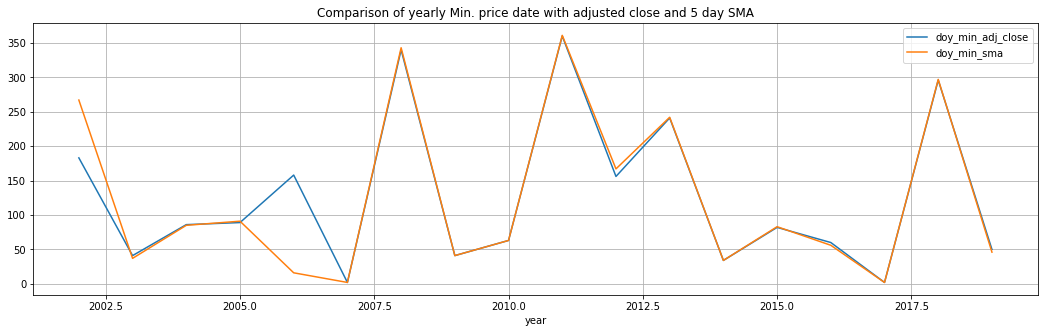

In [18]:
year_agg_data[['doy_min_adj_close', 'doy_min_sma']].plot(figsize=(18,5), grid=True)
plt.title('Comparison of yearly Min. price date with adjusted close and 5 day SMA');

## Build Train-Test Datasets

Now, Let's divide the data into a training and test set. Once done so, we can plot both on the same figure in order to get a feeling of how does our Time Series looks like

In [19]:
frequency = int(round(len(data) / years_of_data, 0))
print('Average no. of records per year:', frequency)
cross_val = min(years_of_data - min_train_data_years, max_cross_val)
print('No. of cross validations, Test data period:', cross_val)
#test_data_years = min(years_of_data - min_train_data_years, max_cross_val)
#print('Test data period:', test_data_years, 'years')
train_data_years = len(year_agg_data) - cross_val
print('Train data period:', train_data_years, 'years')
split_year = current_year - cross_val
print('Cross validation begins from:', split_year)

Average no. of records per year: 240
No. of cross validations, Test data period: 5
Train data period: 13 years
Cross validation begins from: 2015


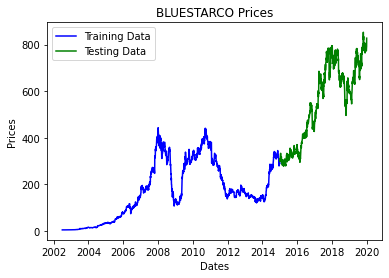

In [20]:
plt.figure(figsize=(6,4))
plt.title(stock_ticker + ' Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(data[data.year < split_year] [agg_value_col], 'blue', label='Training Data')
plt.plot(data[data.year >= split_year] [agg_value_col], 'green', label='Testing Data')
plt.legend();

In [21]:
for i in range(cross_val):
    train_data = data[data.year < split_year + i] 
    test_data = data[data.year == split_year + i] 
    y_train = train_data[agg_value_col].values
    y_test = test_data[agg_value_col].values
    print(train_data.index.year.unique().values, test_data.index.year.unique().values)

[2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014] [2015]
[2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015] [2016]
[2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016] [2017]
[2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017] [2018]
[2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017 2018] [2019]


### Auto-correlation plots
Before we start working on Time Series forecasting, Let's analyse the autocorrelation plot of the “Open” feature with respect to a few lag values

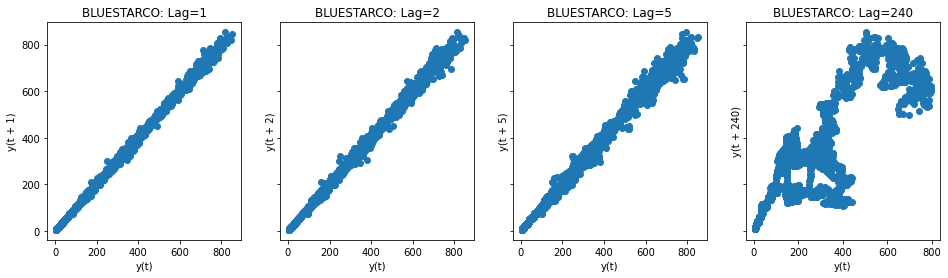

In [22]:
#from pandas.plotting import lag_plot
lags = [1, 2, 5, frequency]

fig, axes = plt.subplots(cnt_stocks, 4, squeeze=False, sharey='row'
                         , figsize=(16, 4*cnt_stocks))
plt.title('Autocorrelation plot')

for stk in range(cnt_stocks):
    for ax_col in range(4):
        axis = axes[stk][ax_col]
        pd.plotting.lag_plot(data[agg_value_col], lag=lags[ax_col], ax=axis)
        #axis.set_ylabel(stock_tickers[stk])
        axis.set_title(f"{stock_tickers[stk]}: Lag={lags[ax_col]}")

plt.show()

We see a definite linear trend in the auto-correlation plot telling us there is some correlation in prices with respect to prices from previous 1 / 5 days of lag which sets up the stage of forecasting future prices based on past price data 

### Check for stationarity (Rolling mean and stdev)

In [23]:
data_series = data[agg_value_col]
data_diff = data_series.diff(periods=1).dropna(inplace = False)

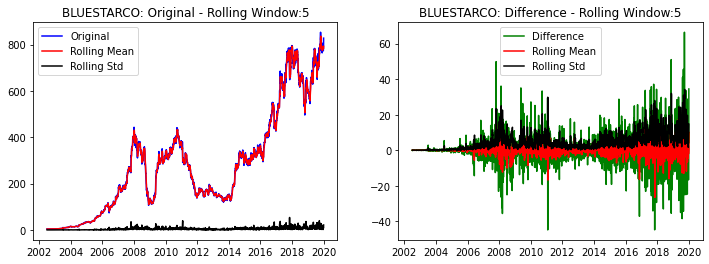

In [24]:
#Plot rolling statistics:
columns = 2
fig, axes = plt.subplots(cnt_stocks, columns, squeeze=False, #sharey='row',
                             figsize=(12, 4*cnt_stocks) )
plt.title('Rolling Mean & Standard Deviation');


for stk in range(cnt_stocks):
    axis = axes[stk][0]
    #Determing rolling statistics
    rolmean = data_series.rolling(eda_window).mean()
    rolstd = data_series.rolling(eda_window).std()
    orig = axis.plot(data_series, color='blue',label='Original')
    mean = axis.plot(rolmean, color='red', label='Rolling Mean')
    std = axis.plot(rolstd, color='black', label = 'Rolling Std')
    axis.legend(loc='best')
    axis.set_title(f"{stock_tickers[stk]}: Original - Rolling Window:{eda_window}")
    
    ax_col = 1
    axis = axes[stk][ax_col]
    diff_rolmean = data_diff.rolling(eda_window).mean()
    diff_rolstd = data_diff.rolling(eda_window).std()
    diff = axis.plot(data_diff, color='green',label='Difference')
    diff_mean = axis.plot(diff_rolmean, color='red', label='Rolling Mean')
    diff_std = axis.plot(diff_rolstd, color='black', label = 'Rolling Std')
    axis.legend(loc='best')
    axis.set_title(f"{stock_tickers[stk]}: Difference - Rolling Window:{eda_window}")
    
plt.show()

### Augmented Dickey–Fuller test

In [25]:
adf_output = pd.DataFrame(index = ['Original','Difference'],
                      columns = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'
                                 , 'Critical Value (1%)', 'Critical Value (5%)' , 'Critical Value (10%)'])
adf_orig = adfuller(data_series, autolag='AIC')
adf_output.loc[adf_output.index[0]][0:4] = adf_orig[0:4]
adf_output.loc[adf_output.index[0]][4:7] = list(adf_orig[4].values())

adf_diff = adfuller(data_diff, autolag='AIC')
adf_output.loc[adf_output.index[1]][0:4] = adf_diff[0:4]
adf_output.loc[adf_output.index[1]][4:7] = list(adf_diff[4].values())
print('Output of ADF test')
adf_output

Output of ADF test


,Test Statistic,p-value,#Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
Original,-0.142985,0.944985,29,4286,-3.43188,-2.86221,-2.56713
Difference,-11.7383,1.29191e-21,31,4283,-3.43188,-2.86222,-2.56713


If the p-value is small beyond a specific significance level threshold, let's consider that to be a standard value of 0.05, then we can say the series is stationary. From the above statistics, we can observe that the p-value is very high for orignal data, which proves that our series is not stationary. To get stationary data, there are many techniques. We can use log, differencing and so on. 

<font color="orange">After differencing, the p-value is extremely small. Hence, it is evident that series becomes stationary after applying first order differencing</font>

Also Test Statistic is less than critical values, indicating stationarity.

##### Plot ACF and PACF on the original train series

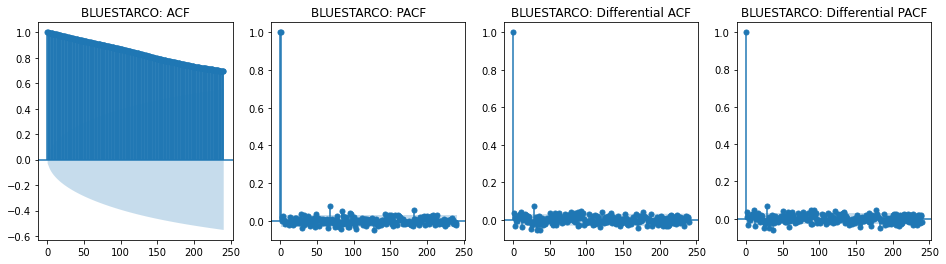

In [26]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#Note:  Same is in pmdarima package via a wrapper function

columns = 4
fig, axes = plt.subplots(cnt_stocks, columns, squeeze=False, #sharey='row',
                             figsize=(16, 4*cnt_stocks) )
plt.title('ACF/PACF');

for stk in range(cnt_stocks):
    axis = axes[stk][0]
    plot_acf(data_series, ax=axis, lags=frequency)
    axis.set_title(f"{stock_tickers[stk]}: ACF")
    
    axis = axes[stk][1]
    plot_pacf(data_series, ax=axis, lags=frequency)
    axis.set_title(f"{stock_tickers[stk]}: PACF")
    
    axis = axes[stk][2]
    plot_acf(data_diff, ax=axis, lags=frequency)
    axis.set_title(f"{stock_tickers[stk]}: Differential ACF")
    
    axis = axes[stk][3]
    plot_pacf(data_diff, ax=axis, lags=frequency)
    axis.set_title(f"{stock_tickers[stk]}: Differential PACF")
    
plt.show()

As per the above plots, stationarity is observed after 1 level of differentiation. 
<br>However, there is no definite trend observed to derive p,q and P,Q values for ARIMA model

### Get rolling yearly seasonality using Seasonal decompose

<br> For daily data with yearly sesonality, m = 365.25
<br> However in our case we have @245 records per year, hence, m = @245

In [27]:
sd_modes = ['additive', 'multiplicative']
sd_algos = ['sm', 'pmd']
sd_dict = {} 
for key in sd_algos: 
    for value in sd_modes: 
        sd_dict[f'{key}_{value[0:3]}'] = value 

start_from = split_year + 1 - min_train_data_years
sd_data = data[data.year >= start_from - 1][[group_by_col]]

#Running seasonal_decompose for cross validation years        
for i in range(cross_val + min_train_data_years - 1):
    pred_year = start_from + i
    #print(pred_year)
    #y_train = data[data.year < pred_year][[agg_value_col]]
    y_train = data[data.year < pred_year][agg_value_col]
    train_years = len(y_train.index.year.unique())
    freq = int(round((len(y_train) / train_years), 0))
    
    for mode in sd_modes:
        #seasonal_decompose using statsmodels package
        sd = seasonal_decompose(y_train, model=mode, period=freq)
        latest_year_cnt = len(data[data.year == y_train.index.year.max()])
        sd_data.loc[y_train.index[-latest_year_cnt:], f'sm_{mode[0:3]}'] = pd.Series(sd.seasonal[-latest_year_cnt:], index = y_train.index[-latest_year_cnt:])  
        #seasonal_decompose using pmdarima package
        pmd_sd = pm.arima.decompose(y_train.values, type_=mode, m=freq, filter_=None)
        sd_data.loc[y_train.index[-latest_year_cnt:], f'pmd_{mode[0:3]}'] = pd.Series(pmd_sd.seasonal[-latest_year_cnt:], index = y_train.index[-latest_year_cnt:])
               
sd_data.dropna()

,year,sm_add,pmd_add,sm_mul,pmd_mul
date,,,,,
2010-01-04,2010,3.591987,2.957415,0.993179,0.969359
2010-01-05,2010,1.420680,0.784427,0.989458,0.965733
2010-01-06,2010,3.115685,2.481754,0.990161,0.966419
2010-01-07,2010,3.932881,3.297223,0.999709,0.975716
2010-01-08,2010,3.861226,3.224363,0.993399,0.969545
...,...,...,...,...,...
2018-12-24,2018,-13.878756,-13.183745,0.933752,0.920826
2018-12-26,2018,-12.375636,-11.681356,0.937427,0.924447
2018-12-27,2018,-10.667324,-9.972396,0.943787,0.930725


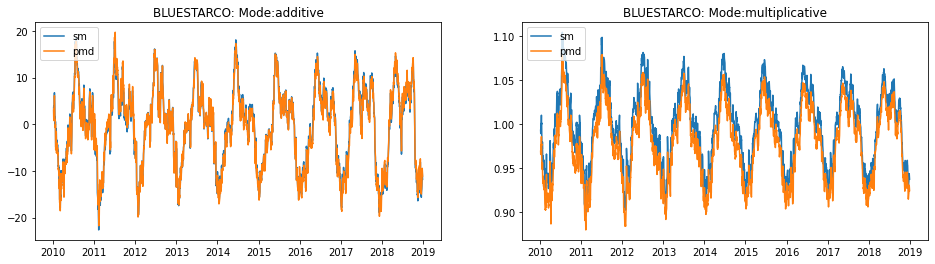

In [28]:
#Plot the Seasonal decompose output:
columns = len(sd_modes)
rows = cnt_stocks
fig, axes = plt.subplots(rows, columns, squeeze=False, #sharey='row',
                             figsize=(16, 4*rows) )
plt.title('Seasonal decompose output');

for stk in range(cnt_stocks):
    for m in range(columns):
        sp = axes[stk][m]
        key = f'_{sd_modes[m][0:3]}'            
        sp.plot(sd_data.filter(regex=key, axis=1))            
        sp.legend(sd_algos, loc='upper left')
        sp.set_title(f"{stock_tickers[stk]}: Mode:{sd_modes[m]}")

plt.show()

In [29]:
#Get yearwise min. price
sd_agg = sd_data.groupby(group_by_col).idxmin().dropna()
sd_agg

,sm_add,pmd_add,sm_mul,pmd_mul
year,,,,
2010,2010-03-04,2010-03-04,2010-04-06,2010-04-06
2011,2011-02-09,2011-02-10,2011-02-09,2011-02-10
2012,2012-01-25,2012-01-25,2012-01-30,2012-01-30
2013,2013-01-21,2013-01-22,2013-01-21,2013-01-22
2014,2014-01-14,2014-01-14,2014-01-14,2014-01-14
2015,2015-01-06,2015-01-06,2015-01-06,2015-01-06
2016,2016-01-20,2016-01-21,2016-01-18,2016-01-19
2017,2017-12-11,2017-12-12,2017-01-06,2017-01-09
2018,2018-11-19,2018-11-19,2018-12-20,2018-12-20


In [30]:
#Get working day for given dates
def get_wd(row):
    #print(row)
    ref = pd.Series(index = row.index)
    for i in range(len(row)):
        ref.loc[row.index[i]] = (wd_series[row[i]])
    #print(ref)
    return ref

#Get percentile of sma for given dates
def get_pctile(row):
    #print(row)
    ref = pd.Series(index = row.index)
    for i in range(len(row)):
        ref.loc[row.index[i]] = (pctile_series[row[i]])
    #print(ref)
    return ref

In [31]:

sd_output = sd_agg.apply(get_wd, axis = 1)
sd_output

,sm_add,pmd_add,sm_mul,pmd_mul
year,,,,
2010,41.0,41.0,62.0,62.0
2011,27.0,28.0,27.0,28.0
2012,18.0,18.0,20.0,20.0
2013,15.0,16.0,15.0,16.0
2014,10.0,10.0,10.0,10.0
2015,4.0,4.0,4.0,4.0
2016,14.0,15.0,12.0,13.0
2017,235.0,236.0,5.0,6.0
2018,218.0,218.0,240.0,240.0


In [32]:
#Get avg. seasonality for last 5 years w/o ignoring the outlier to show the diff. betn. with and w/o outliers
sd_rm = sd_output.rolling(min_train_data_years).mean().dropna()
#sd_refined = df * df.sub(df.rolling(5).mean()).div(df.rolling(5).std()).abs().lt(1.25)
sd_rm

,sm_add,pmd_add,sm_mul,pmd_mul
year,,,,
2014,22.2,22.6,26.8,27.2
2015,14.8,15.2,15.2,15.6
2016,12.2,12.6,12.2,12.6
2017,55.6,56.2,9.2,9.8
2018,96.2,96.6,54.2,54.6


In [33]:
#Get avg. seasonality for last 5 years while ignoring the outlier years
sd_refined = pd.DataFrame(columns = sd_rm.columns)
for i in range(cross_val):    
    pred_year = split_year + i
    #print(pred_year)    
    df = sd_output.loc[pred_year-5:pred_year-1]
    #print(df)
    #1.25 is the average ratio of error to deviation for marking outliers, TO - DO ignore std < 5
    #outlier_diff = 5
    #ref_df = df * df.sub(df.mean()).abs().lt(outlier_diff) - not the right way
    outlier_ratio = 1.25
    #print(df.mean(), df.std(), df.sub(df.mean()).div(df.std()).abs())
    ref_df = df * df.sub(df.mean()).div(df.std(), ).abs().lt(outlier_ratio)      
    #Replace 0 with NaN to ensure that outliers are ignored while calculating mean
    ref_df.replace(0, np.nan, inplace=True)
    #print(ref_df)
    #print(ref_df.mean())
    sd_refined = sd_refined.append(ref_df.mean(), ignore_index=True)

#Increment the year by 1 to indicate that this is the prediction for next year
sd_refined.index += split_year
#Add the actual output column - wd_min_sma
sd_refined = year_agg_data[['wd_min_sma']].join(sd_refined, how='inner')
#Rename column to indicate the correct interpretation
sd_refined.index.name = 'pred_year'
sd_refined

,wd_min_sma,sm_add,pmd_add,sm_mul,pmd_mul
pred_year,,,,,
2015,56,17.50,18.00,18.000000,18.500000
2016,39,11.75,12.00,15.000000,15.333333
2017,1,14.25,14.75,12.333333,14.750000
2018,201,10.75,11.25,9.200000,8.250000
2019,33,96.20,96.60,7.750000,8.250000


In [34]:
#Get percentile from working day and year
def get_pctile_fron_wd(row):
    ref = row.copy()#pd.Series(index = row.index)
    #print(ref)
    year = row[0]
    #print(year)
    row = row[1:]
    #print(row)
    for i in range(len(row)):
        #print(row[i])
        ref.loc[row.index[i]] = data[(data.year == year) & (data[wd_col] == round(row[i], 0))].pctile[0]
    #print(ref)
    return ref

In [35]:
sd_pctile = sd_refined.reset_index()
sd_pctile = sd_pctile.apply(get_pctile_fron_wd, axis = 1)
sd_pctile.set_index('pred_year', inplace = True)
sd_pctile

,wd_min_sma,sm_add,pmd_add,sm_mul,pmd_mul
pred_year,,,,,
2015.0,0.406504,42.276423,42.276423,42.276423,42.276423
2016.0,0.406504,10.975610,10.975610,11.788618,11.788618
2017.0,0.403226,7.258065,6.048387,6.451613,6.048387
2018.0,0.406504,79.674797,79.674797,94.308943,97.154472
2019.0,0.413223,64.049587,66.528926,12.396694,12.396694


## Holt Winters

In [36]:
hwes_trends = [None, 'additive', 'multiplicative']
hwes_modes = ['additive', 'multiplicative']
     
#hwes_data = data[data.year >= split_year][[group_by_col, agg_value_col, agg_value_col_sma]]
hwes_data = data[data.year >= split_year][[group_by_col, agg_value_col]]
hwes_fcast_metrics = pd.DataFrame(index = [*range(split_year, current_year)]) 
#hwes_fcast_metrics = year_agg_data[-cross_val:][['mean_adj_close']]##Update to use year_agg_data with mean values

#Running Holt Winters forecasting for cross validation years        
for i in range(cross_val):
    pred_year = split_year + i
    #y_train = data[data.year < pred_year][[agg_value_col]]
    y_train = data[data.year < pred_year][agg_value_col]
    y_test = data[data.year == pred_year][agg_value_col]
    train_years = len(y_train.index.year.unique())
    freq = int(round((len(y_train) / train_years), 0))
    
    for mode in hwes_modes:
        for trend in hwes_trends:
            #Excluding extreme scenario when both trend and seasonality are multiplicative
            if (mode != 'multiplicative' or trend != 'multiplicative' ):
                #forecasting
                #trend, seasonal: {“add”, “mul”, “additive”, “multiplicative”, None}, optional
                #initialization_method: None, ‘estimated’(Default), ‘heuristic’, ‘legacy-heuristic’, ‘known’  
                #use_boxcox{True, False, ‘log’, float}, optional
                hwes_model = HWES(y_train, seasonal_periods=freq, trend=trend, seasonal=mode).fit()            
                #print(hwes_model.summary())
                hwes_forecast = hwes_model.forecast(steps=year_agg_data.loc[pred_year, 'record_cnt'])
                #print(hwes_forecast)
                if trend is None:
                     t = 'n'
                else:
                     t = trend[0]
                hwes_data.loc[y_test.index, 
                              f'hwes_t{t}_s{mode[0]}'] = pd.Series(hwes_forecast.values, index = y_test.index) 
                #Set forecast metrics
                hwes_fcast_metrics.loc[pred_year, f'smape_hwes_t{t}_s{mode[0]}'] = smape(y_test, hwes_forecast)
                #mean_absolute_error(y_test, hwes_forecast)
                #sqrt(mean_squared_error(y_test, hwes_forecast)),
            
            #Use break to stop execution after 1 loop for debugging
            #break
        #break
    #break
        
hwes_data, hwes_fcast_metrics

(            year   adj_close  hwes_tn_sa  hwes_ta_sa  hwes_tm_sa  hwes_tn_sm  \
 date                                                                           
 2015-01-01  2015  307.775421  303.121896  303.586718  303.662429  299.547074   
 2015-01-02  2015  306.524689  305.432844  306.341014  306.520789  301.193066   
 2015-01-05  2015  303.884216  302.201098  303.558365  303.829117  293.268907   
 2015-01-06  2015  298.047424  301.662179  303.435480  303.812262  286.349274   
 2015-01-07  2015  298.186401  302.547339  304.705238  305.243999  283.741739   
 ...          ...         ...         ...         ...         ...         ...   
 2019-12-24  2019  772.610962  604.396647  640.619335  607.013512  627.692071   
 2019-12-26  2019  778.861145  605.308408  641.684061  607.963234  618.754984   
 2019-12-27  2019  788.900818  604.045673  640.557880  606.567925  600.210510   
 2019-12-30  2019  793.133179  600.840967  637.516123  603.154912  574.802834   
 2019-12-31  2019  827.63220

As observed in HWES output, with both trend and sesonality set to multiplicative, the output shoots exponetially. Hence, ignore this case.

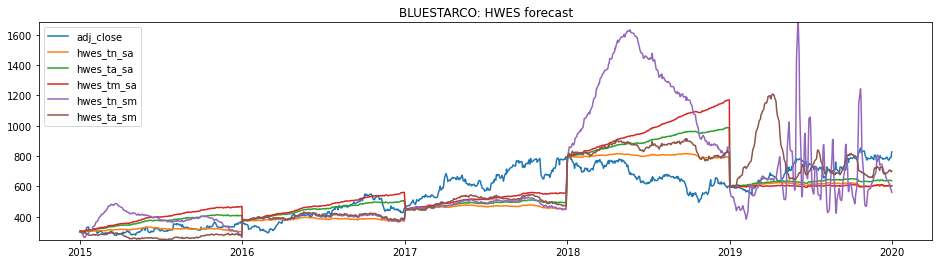

In [37]:
#Plot the HWES forecast output:
columns = 1
rows = cnt_stocks
fig, axes = plt.subplots(rows, columns, squeeze=False, #sharey='row',
                             figsize=(16, 4*rows) )
plt.title('HWES forecast output')

#Drop unwated columns from plot = year
hwes_data.drop([group_by_col], axis = 1, inplace = True)

for stk in range(cnt_stocks):    
    splt = axes[stk][0]                    
    splt.plot(hwes_data) 
    #Set ylimit for better visualization
    splt.set_ylim(hwes_data.min().min(), min(data[agg_value_col].max() * 2, hwes_data.max().max()))
    splt.legend(hwes_data.columns, loc='best')
    splt.set_title(f"{stock_tickers[stk]}: HWES forecast")

plt.show()

In [38]:
smape_avg = hwes_fcast_metrics.mean().sort_values(ascending=True)
print('Holt Winters Exponential Smoothing: Best output achieved with trend:', 
      smape_avg.index[0][-4], 'and seasonality:', smape_avg.index[0][-1])
smape_avg

Holt Winters Exponential Smoothing: Best output achieved with trend: n and seasonality: a


smape_hwes_tn_sa    17.105558
smape_hwes_ta_sm    18.419805
smape_hwes_ta_sa    18.789850
smape_hwes_tm_sa    21.690614
smape_hwes_tn_sm    27.363915
dtype: float64

## Auto Arima

###### Getting value of differencing term, d and seasonal differencing term, D

In [39]:
y_data = data[agg_value_col]

##directly estimate the number of differences required
kpss_diffs = pm.arima.ndiffs(y_data, alpha=0.05, test='kpss', max_d=6)
adf_diffs = pm.arima.ndiffs(y_data, alpha=0.05, test='adf', max_d=6)
pp_diffs = pm.arima.ndiffs(y_data, alpha=0.05, test='pp', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs, pp_diffs)

print(f"Estimated differencing term, d: {n_diffs}")

##directly estimate the number of seasonal differences
ocsb_sdiffs = pm.arima.nsdiffs(y_data, m=frequency, test='ocsb', max_D=6)
ch_sdiffs = pm.arima.nsdiffs(y_data, m=frequency, test='ch', max_D=6)
n_sdiffs = max(ocsb_sdiffs, ch_sdiffs)

print(f"Estimated seasonal differencing term, D: {n_sdiffs}")

Estimated differencing term, d: 1
Estimated seasonal differencing term, D: 0


###### Auto Arima forecasting

###### Training with yearly seasonality using FourierFeaturizer
As suggested in PMD Arima documentation - For long seasonal periods, we will use FourierFeaturizer as exogenous features

In [40]:
pmd_modes = ['ff', 'ff_date'] #, 'ff_exog', 'ff_exog_date'] 
date_features = ["year","month","week","day_of_week","day_of_month","day_of_year"]
aa_fcast_data = data[data.year >= split_year][[group_by_col, agg_value_col]]
#aa_fcast_metrics = year_agg_data[-cross_val:][['mean_adj_close']] # With mean value
aa_fcast_metrics = pd.DataFrame(index = [*range(split_year, current_year)]) # Without mean value

#FourierFeaturizer
trans = pm.preprocessing.FourierFeaturizer(m=frequency, k=4) #k = no. of Sin/Cos terms - columns = k*2
y_prime, ff_data = trans.fit_transform(data[agg_value_col], exogenous=data[date_features])

#Running AutoARIMA forecasting for cross validation years
for i in range(cross_val):
    pred_year = split_year + i
    train_data = data[data.year < pred_year][[agg_value_col] + date_features]
    y_train = train_data[agg_value_col]
    test_data = data[data.year == pred_year][[agg_value_col] + date_features]
    y_test = test_data[agg_value_col] #data[data.year == pred_year][agg_value_col]
    train_years = len(y_train.index.year.unique())
    freq = int(round((len(y_train) / train_years), 0))
    train_ff_data = ff_data[ff_data.year < pred_year]
    test_ff_data = ff_data[ff_data.year == pred_year]
    
    train_exog = None
    test_exog = None
    for mode in pmd_modes:
        if (mode == pmd_modes[0]):
            train_exog = train_ff_data.drop(date_features, axis=1)#Drop other exogenous features if, added
            test_exog = test_ff_data.drop(date_features, axis=1)#Drop other exogenous features if, added
        else:
            train_exog = train_ff_data.copy()
            test_exog = test_ff_data.copy()
            
        #forecasting
        aa_model = pm.auto_arima(y_train, exogenous=train_exog, d=n_diffs, max_p=6, 
                         seasonal=False, stepwise=True, suppress_warnings=True, trace=False)
        print('AutoArima Model order:', aa_model.order)
        #print(aa_model.summary())
        #aa_fcast, conf_int = aa_model.predict(n_periods=len(y_test), exogenous=test_exog, return_conf_int=True)
        aa_fcast = aa_model.predict(n_periods=len(y_test), exogenous=test_exog, return_conf_int=False)
        #print(aa_fcast)
        aa_fcast_data.loc[y_test.index, f'aa_{mode}'] = pd.Series(aa_fcast, index = y_test.index) 
        #Derive forecast metrics
        aa_fcast_metrics.loc[pred_year, f'smape_aa_{mode}'] = smape(y_test, aa_fcast)
        print('Forecasting completed for', pred_year, 'mode:', mode, 'using ARIMA order:', aa_model.order)
        #Use break to stop execution after 1 loop for debugging
        #break        
    #break
        
aa_fcast_data, aa_fcast_metrics

AutoArima Model order: (1, 1, 2)
Forecasting completed for 2015 mode: ff using ARIMA order: (1, 1, 2)
AutoArima Model order: (0, 1, 0)
Forecasting completed for 2015 mode: ff_date using ARIMA order: (0, 1, 0)
AutoArima Model order: (2, 1, 2)
Forecasting completed for 2016 mode: ff using ARIMA order: (2, 1, 2)
AutoArima Model order: (0, 1, 0)
Forecasting completed for 2016 mode: ff_date using ARIMA order: (0, 1, 0)
AutoArima Model order: (0, 1, 1)
Forecasting completed for 2017 mode: ff using ARIMA order: (0, 1, 1)
AutoArima Model order: (0, 1, 0)
Forecasting completed for 2017 mode: ff_date using ARIMA order: (0, 1, 0)
AutoArima Model order: (1, 1, 0)
Forecasting completed for 2018 mode: ff using ARIMA order: (1, 1, 0)
AutoArima Model order: (1, 1, 0)
Forecasting completed for 2018 mode: ff_date using ARIMA order: (1, 1, 0)
AutoArima Model order: (2, 1, 0)
Forecasting completed for 2019 mode: ff using ARIMA order: (2, 1, 0)
AutoArima Model order: (0, 1, 0)
Forecasting completed for 201

(            year   adj_close       aa_ff  aa_ff_date
 date                                                
 2015-01-01  2015  307.775421  305.880651  307.527493
 2015-01-02  2015  306.524689  305.368739  307.063087
 2015-01-05  2015  303.884216  304.872349  306.486425
 2015-01-06  2015  298.047424  304.395206  306.061879
 2015-01-07  2015  298.186401  303.940943  305.662589
 ...          ...         ...         ...         ...
 2019-12-24  2019  772.610962  604.433855  651.918972
 2019-12-26  2019  778.861145  604.487095  652.395659
 2019-12-27  2019  788.900818  604.531780  652.651375
 2019-12-30  2019  793.133179  604.568071  652.794525
 2019-12-31  2019  827.632202  604.596308  653.035633
 
 [1228 rows x 4 columns],
       smape_aa_ff  smape_aa_ff_date
 2015     5.497851          5.915347
 2016    11.935255         11.855432
 2017    27.227328         26.058869
 2018    21.976931         22.573853
 2019    14.665615         10.984131)

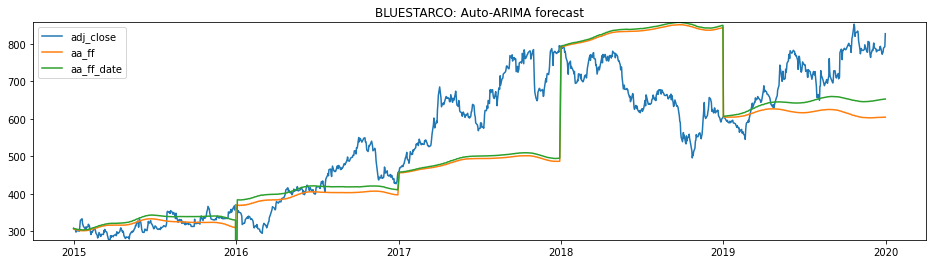

In [41]:
#Plot the Auto-ARIMA forecast output:
columns = 1
rows = cnt_stocks
fig, axes = plt.subplots(rows, columns, squeeze=False, #sharey='row',
                             figsize=(16, 4*rows) )
plt.title('Auto-ARIMA with FourierFeaturizer forecast output')

#Drop unwated columns from plot = year
aa_fcast_data.drop([group_by_col], axis = 1, inplace = True)

for stk in range(cnt_stocks):    
    splt = axes[stk][0]                    
    splt.plot(aa_fcast_data) 
    #Set ylimit for better visualization
    splt.set_ylim(aa_fcast_data[agg_value_col].min(), min(data[agg_value_col].max() * 2, aa_fcast_data.max().max()))
    splt.legend(aa_fcast_data.columns, loc='best')
    splt.set_title(f"{stock_tickers[stk]}: Auto-ARIMA forecast")

plt.show()

In [42]:
aa_smape_avg = aa_fcast_metrics.mean().sort_values(ascending=True)
print('Auto-ARIMA with FourierFeaturizer - Best output achieved with:', aa_smape_avg.index[0])
aa_smape_avg

Auto-ARIMA with FourierFeaturizer - Best output achieved with: smape_aa_ff_date


smape_aa_ff_date    15.477526
smape_aa_ff         16.260596
dtype: float64

As observed in above plot and metrics, there is a significant improvement on adding exogenous features even with same data and model paramters

## Facebook Prophet

In [43]:
#Setting up dataset as per fbprophet requirements
pdata = pd.DataFrame() 
pdata['ds'] = data.index
pdata['y'] = data[agg_value_col].values

#Required for growth = "logistic"
pdata['cap'] = 1.5 * pdata.y.max() #Capping the price growth at 50% of max. value

pdata

,ds,y,cap
0,2002-07-01,3.985216,1279.6138
1,2002-07-02,3.964178,1279.6138
2,2002-07-03,4.024287,1279.6138
3,2002-07-04,4.042319,1279.6138
4,2002-07-05,4.039313,1279.6138
...,...,...,...
4311,2019-12-24,772.610962,1279.6138
4312,2019-12-26,778.861145,1279.6138
4313,2019-12-27,788.900818,1279.6138
4314,2019-12-30,793.133179,1279.6138


In [44]:
#growth = "linear" or "logistic" to specify a linear or logistic trend.
#yearly.seasonality, weekly.seasonality, daily.seasonality  = "auto", TRUE, FALSE or a number of Fourier terms to generate.
#seasonality_mode = "additive" (default) or "multiplicative"
fb_growth = ['linear', 'logistic']
fb_smodes = ['additive', 'multiplicative']
     
fb_data = data[data.year >= split_year][[group_by_col, agg_value_col]]
fb_fcast_metrics = pd.DataFrame(index = [*range(split_year, current_year)]) ##years w/o mean values
#fb_fcast_metrics = year_agg_data[-cross_val:][['mean_adj_close']] ##years with mean values

#Running Prophet forecasting for cross validation years        
for i in range(cross_val):
    pred_year = split_year + i
    
    y_train = pdata[pdata.ds.dt.year < pred_year] 
    y_test = pdata[pdata.ds.dt.year == pred_year]  
    #y_train = data[data.year < pred_year][agg_value_col]
    #y_test = data[data.year == pred_year][agg_value_col]
    train_years = len(y_train.ds.dt.year.unique())
    freq = int(round((len(y_train) / train_years), 0))
    
    for mode in fb_smodes:
        for trend in fb_growth:
            t = trend[0:3]
            m = mode[0:3]
            fb_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, growth=trend, seasonality_mode=mode)
            fb_model.fit(y_train)
            fb_fcast = fb_model.predict(y_test)
            fb_data.loc[y_test.ds, f'fbp_{t}_{m}'] = pd.Series(fb_fcast.yhat.values, index = y_test.ds) 
            fb_data.loc[y_test.ds, f'fbp_yearly_{t}_{m}'] = pd.Series(fb_fcast.yearly.values, index = y_test.ds) 
            #Capture prediction metrics
            fb_fcast_metrics.loc[pred_year, f'smape_fbp_{t}_{m}'] = smape(y_test.y, fb_fcast.yhat)
            #mean_absolute_error(y_test.y, fb_fcast.yhat)
            #sqrt(mean_squared_error(y_test.y, fb_fcast.yhat))
            
            #Use break to stop execution after 1 loop for debugging
            #break
        #break
    #break
        
fb_data, fb_fcast_metrics

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

(            year   adj_close  fbp_lin_add  fbp_yearly_lin_add  fbp_log_add  \
 date                                                                         
 2015-01-01  2015  307.775421   258.457941           -1.107490   263.391023   
 2015-01-02  2015  306.524689   258.672238           -1.042911   263.717042   
 2015-01-05  2015  303.884216   259.215865           -0.948438   264.617702   
 2015-01-06  2015  298.047424   259.349424           -0.964597   264.873138   
 2015-01-07  2015  298.186401   259.452173           -1.011566   265.096844   
 ...          ...         ...          ...                 ...          ...   
 2019-12-24  2019  772.610962   876.647232           -5.828768   891.051958   
 2019-12-26  2019  778.861145   878.407156           -4.744659   892.911936   
 2019-12-27  2019  788.900818   879.375658           -4.114065   893.945045   
 2019-12-30  2019  793.133179   882.545168           -1.958277   897.358160   
 2019-12-31  2019  827.632202   883.656708          

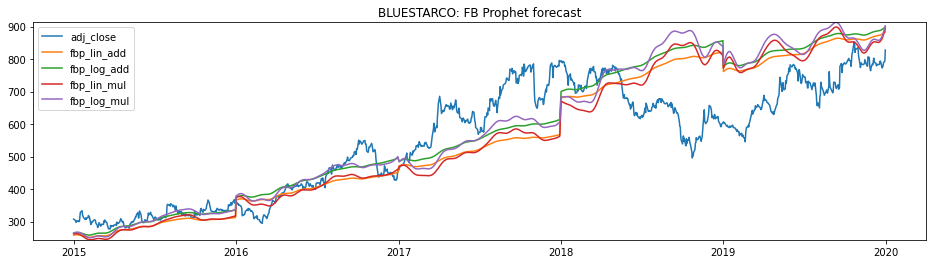

In [45]:
#Plot the Auto-ARIMA forecast output:
columns = 1
rows = cnt_stocks
fig, axes = plt.subplots(rows, columns, squeeze=False, #sharey='row',
                             figsize=(16, 4*rows) )
plt.title('FB Prophet forecast output')

#Drop unwated columns from plot = year
fb_fcast_data = fb_data.drop(fb_data.filter(regex='year').columns, axis = 1)

for stk in range(cnt_stocks):    
    splt = axes[stk][0]                    
    splt.plot(fb_fcast_data) 
    #Set ylimit for better visualization
    splt.set_ylim(fb_fcast_data.min().min(), min(data[agg_value_col].max() * 2, fb_fcast_data.max().max()))
    splt.legend(fb_fcast_data.columns, loc='best')
    splt.set_title(f"{stock_tickers[stk]}: FB Prophet forecast")

plt.show()

In [46]:
fb_smape_avg = fb_fcast_metrics.mean().sort_values(ascending=True)
print('FB Prophet - Best output achieved with:', fb_smape_avg.index[0])
fb_smape_avg

FB Prophet - Best output achieved with: smape_fbp_log_add


smape_fbp_log_add    12.959065
smape_fbp_log_mul    13.514701
smape_fbp_lin_add    14.244428
smape_fbp_lin_mul    14.728506
dtype: float64

With all combinations, there is always as degradation observed with seasonality_mode = "multiplicative"

In [47]:
fcast_metrics = pd.concat([hwes_fcast_metrics, aa_fcast_metrics, fb_fcast_metrics], axis=1)
fcast_metrics

,smape_hwes_tn_sa,smape_hwes_ta_sa,smape_hwes_tm_sa,smape_hwes_tn_sm,smape_hwes_ta_sm,smape_aa_ff,smape_aa_ff_date,smape_fbp_lin_add,smape_fbp_log_add,smape_fbp_lin_mul,smape_fbp_log_mul
2015,5.646233,15.345516,21.661731,21.440540,15.363174,5.497851,5.915347,10.085556,6.053640,10.193445,6.970175
2016,15.039885,9.772763,12.465654,13.117240,12.425532,11.935255,11.855432,8.277633,7.924164,7.581296,7.100888
2017,31.256078,27.054238,21.319492,27.277878,23.753508,27.227328,26.058869,20.432513,15.062653,20.927038,15.222283
2018,18.688698,29.473621,36.771108,55.508195,24.060490,21.976931,22.573853,16.910855,18.296507,18.748691,20.198608
2019,14.896899,12.303112,16.235086,19.475724,16.496320,14.665615,10.984131,15.515583,17.458361,16.192060,18.081551


In [48]:
smape_avg = fcast_metrics.mean().sort_values(ascending=True)
print('Best price forecast output achieved with:', smape_avg.index[0])
smape_avg

Best price forecast output achieved with: smape_fbp_log_add


smape_fbp_log_add    12.959065
smape_fbp_log_mul    13.514701
smape_fbp_lin_add    14.244428
smape_fbp_lin_mul    14.728506
smape_aa_ff_date     15.477526
smape_aa_ff          16.260596
smape_hwes_tn_sa     17.105558
smape_hwes_ta_sm     18.419805
smape_hwes_ta_sa     18.789850
smape_hwes_tm_sa     21.690614
smape_hwes_tn_sm     27.363915
dtype: float64

Based on above results, best models for different algorithms are as follows:
<ul>
    <li>HWES: trend=None, seasonality mode ='add'</li>
    <li>AutoArima: Fourier Featurizer with date parts as exogenous features</li>
    <li>Prophet: yearly seasonality, logistic growth, seasonality mode ='add'</li>
</ul>

### Derive the best time of the year to invest based on price forecast

In [49]:
fcast_data = hwes_data.drop([agg_value_col]
                           , axis = 1).join(aa_fcast_data.drop([agg_value_col]
                                                               , axis = 1)).join(fb_data.drop([agg_value_col, group_by_col]
                                                                                              , axis = 1))
fcast_data

,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date,fbp_lin_add,fbp_yearly_lin_add,fbp_log_add,fbp_yearly_log_add,fbp_lin_mul,fbp_yearly_lin_mul,fbp_log_mul,fbp_yearly_log_mul
date,,,,,,,,,,,,,,,
2015-01-01,303.121896,303.586718,303.662429,299.547074,300.321541,305.880651,307.527493,258.457941,-1.107490,263.391023,-2.015724,262.516874,0.011454,265.359399,0.001575
2015-01-02,305.432844,306.341014,306.520789,301.193066,304.090059,305.368739,307.063087,258.672238,-1.042911,263.717042,-1.872969,262.717996,0.011648,265.810248,0.002585
2015-01-05,302.201098,303.558365,303.829117,293.268907,299.104169,304.872349,306.486425,259.215865,-0.948438,264.617702,-1.522661,263.056707,0.011208,266.965871,0.004863
2015-01-06,301.662179,303.435480,303.812262,286.349274,295.987031,304.395206,306.061879,259.349424,-0.964597,264.873138,-1.450864,263.063492,0.010655,267.256070,0.005263
2015-01-07,302.547339,304.705238,305.243999,283.741739,299.103609,303.940943,305.662589,259.452173,-1.011566,265.096844,-1.410888,263.009069,0.009866,267.484507,0.005429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,604.396647,640.619335,607.013512,627.692071,701.351884,604.433855,651.918972,876.647232,-5.828768,891.051958,-6.367348,863.795184,-0.029840,870.268073,-0.037842
2019-12-26,605.308408,641.684061,607.963234,618.754984,708.133485,604.487095,652.395659,878.407156,-4.744659,892.911936,-5.135729,870.649525,-0.022898,877.754595,-0.030244
2019-12-27,604.045673,640.557880,606.567925,600.210510,708.425764,604.531780,652.651375,879.375658,-4.114065,893.945045,-4.416577,874.575659,-0.018871,882.073999,-0.025812


In [50]:
fcast_data.groupby([fcast_data.index.year]).idxmin().apply(get_wd, axis = 1)

,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date,fbp_lin_add,fbp_yearly_lin_add,fbp_log_add,fbp_yearly_log_add,fbp_lin_mul,fbp_yearly_lin_mul,fbp_log_mul,fbp_yearly_log_mul
date,,,,,,,,,,,,,,,
2015,4.0,4.0,1.0,8.0,135.0,16.0,14.0,25.0,49.0,25.0,50.0,27.0,50.0,26.0,50.0
2016,234.0,1.0,1.0,237.0,1.0,6.0,1.0,26.0,53.0,1.0,52.0,52.0,54.0,27.0,53.0
2017,7.0,6.0,4.0,4.0,28.0,3.0,1.0,27.0,48.0,1.0,49.0,46.0,48.0,30.0,48.0
2018,214.0,1.0,1.0,239.0,211.0,1.0,1.0,1.0,48.0,1.0,48.0,44.0,46.0,45.0,47.0
2019,209.0,1.0,115.0,28.0,1.0,217.0,1.0,1.0,47.0,1.0,212.0,29.0,210.0,29.0,210.0


In [51]:
wd_min_fcast = sd_refined.join(fcast_data.groupby([fcast_data.index.year]).idxmin().apply(get_wd, axis = 1))
wd_min_fcast

,wd_min_sma,sm_add,pmd_add,sm_mul,pmd_mul,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date,fbp_lin_add,fbp_yearly_lin_add,fbp_log_add,fbp_yearly_log_add,fbp_lin_mul,fbp_yearly_lin_mul,fbp_log_mul,fbp_yearly_log_mul
pred_year,,,,,,,,,,,,,,,,,,,,
2015,56,17.50,18.00,18.000000,18.500000,4.0,4.0,1.0,8.0,135.0,16.0,14.0,25.0,49.0,25.0,50.0,27.0,50.0,26.0,50.0
2016,39,11.75,12.00,15.000000,15.333333,234.0,1.0,1.0,237.0,1.0,6.0,1.0,26.0,53.0,1.0,52.0,52.0,54.0,27.0,53.0
2017,1,14.25,14.75,12.333333,14.750000,7.0,6.0,4.0,4.0,28.0,3.0,1.0,27.0,48.0,1.0,49.0,46.0,48.0,30.0,48.0
2018,201,10.75,11.25,9.200000,8.250000,214.0,1.0,1.0,239.0,211.0,1.0,1.0,1.0,48.0,1.0,48.0,44.0,46.0,45.0,47.0
2019,33,96.20,96.60,7.750000,8.250000,209.0,1.0,115.0,28.0,1.0,217.0,1.0,1.0,47.0,1.0,212.0,29.0,210.0,29.0,210.0


In [52]:
output_mae = wd_min_fcast.apply(lambda x : abs(x - x['wd_min_sma']), axis=1).drop('wd_min_sma', axis = 1)
output_mae 

,sm_add,pmd_add,sm_mul,pmd_mul,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date,fbp_lin_add,fbp_yearly_lin_add,fbp_log_add,fbp_yearly_log_add,fbp_lin_mul,fbp_yearly_lin_mul,fbp_log_mul,fbp_yearly_log_mul
pred_year,,,,,,,,,,,,,,,,,,,
2015,38.50,38.00,38.000000,37.500000,52.0,52.0,55.0,48.0,79.0,40.0,42.0,31.0,7.0,31.0,6.0,29.0,6.0,30.0,6.0
2016,27.25,27.00,24.000000,23.666667,195.0,38.0,38.0,198.0,38.0,33.0,38.0,13.0,14.0,38.0,13.0,13.0,15.0,12.0,14.0
2017,13.25,13.75,11.333333,13.750000,6.0,5.0,3.0,3.0,27.0,2.0,0.0,26.0,47.0,0.0,48.0,45.0,47.0,29.0,47.0
2018,190.25,189.75,191.800000,192.750000,13.0,200.0,200.0,38.0,10.0,200.0,200.0,200.0,153.0,200.0,153.0,157.0,155.0,156.0,154.0
2019,63.20,63.60,25.250000,24.750000,176.0,32.0,82.0,5.0,32.0,184.0,32.0,32.0,14.0,32.0,179.0,4.0,177.0,4.0,177.0


In [53]:
best_mae = output_mae[-1:].transpose().sort_values(by=current_year-1, ascending=True)
best_mae #[:5]

pred_year,2019
fbp_log_mul,4.00
fbp_lin_mul,4.00
hwes_tn_sm,5.00
fbp_yearly_lin_add,14.00
pmd_mul,24.75
sm_mul,25.25
hwes_ta_sa,32.00
hwes_ta_sm,32.00
aa_ff_date,32.00
fbp_lin_add,32.00


In [54]:
print('Top 5 best sesonality forecast for 2019 for', stock_ticker, ':\n', best_mae.index[0:5])

Top 5 best sesonality forecast for 2019 for BLUESTARCO :
 Index(['fbp_log_mul', 'fbp_lin_mul', 'hwes_tn_sm', 'fbp_yearly_lin_add',
       'pmd_mul'],
      dtype='object')


Top models for each technique:
<ol>
    <li>FB Prophet yearly pattern (Seasonality: Additive): <font color="red">0 days</font></li>
    <li>FB Prophet (Seasonality: Multiplicative): <font color="red">1 day</font></li>
    <li>AutoArima (using Fourier Featurizer): <font color="red">1 day</font></li>
    <li>HWES (Seasonality: Additive): <font color="red">4 days</font></li>
    <li>Seasonal decompose (Seasonality: Additive): <font color="red">6.4 days</font></li>
</ol>

In [55]:
#Threshold for accuracy = 10 days
threshold = 15
output_mae.loc[:, output_mae[output_mae <= threshold].count() >= 3]

,fbp_yearly_lin_add
pred_year,
2015,7.0
2016,14.0
2017,47.0
2018,153.0
2019,14.0


In [56]:
accurate_mae = output_mae[ output_mae <= threshold ].count()
consistent = accurate_mae[accurate_mae > 2].sort_values(ascending = False)

In [57]:
print('Algorithms with most accurate forecast for last 5 years', stock_ticker, ':\n', consistent[0:3])

Algorithms with most accurate forecast for last 5 years BLUESTARCO :
 fbp_yearly_lin_add    3
dtype: int64


### Accuracy based on Percentile of price 

In [58]:
wd_min_fcast

,wd_min_sma,sm_add,pmd_add,sm_mul,pmd_mul,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date,fbp_lin_add,fbp_yearly_lin_add,fbp_log_add,fbp_yearly_log_add,fbp_lin_mul,fbp_yearly_lin_mul,fbp_log_mul,fbp_yearly_log_mul
pred_year,,,,,,,,,,,,,,,,,,,,
2015,56,17.50,18.00,18.000000,18.500000,4.0,4.0,1.0,8.0,135.0,16.0,14.0,25.0,49.0,25.0,50.0,27.0,50.0,26.0,50.0
2016,39,11.75,12.00,15.000000,15.333333,234.0,1.0,1.0,237.0,1.0,6.0,1.0,26.0,53.0,1.0,52.0,52.0,54.0,27.0,53.0
2017,1,14.25,14.75,12.333333,14.750000,7.0,6.0,4.0,4.0,28.0,3.0,1.0,27.0,48.0,1.0,49.0,46.0,48.0,30.0,48.0
2018,201,10.75,11.25,9.200000,8.250000,214.0,1.0,1.0,239.0,211.0,1.0,1.0,1.0,48.0,1.0,48.0,44.0,46.0,45.0,47.0
2019,33,96.20,96.60,7.750000,8.250000,209.0,1.0,115.0,28.0,1.0,217.0,1.0,1.0,47.0,1.0,212.0,29.0,210.0,29.0,210.0


In [59]:
fcast_pctile = wd_min_fcast.reset_index()
fcast_pctile = fcast_pctile.apply(get_pctile_fron_wd, axis = 1)
fcast_pctile.set_index('pred_year', inplace = True)
fcast_pctile

,wd_min_sma,sm_add,pmd_add,sm_mul,pmd_mul,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date,fbp_lin_add,fbp_yearly_lin_add,fbp_log_add,fbp_yearly_log_add,fbp_lin_mul,fbp_yearly_lin_mul,fbp_log_mul,fbp_yearly_log_mul
pred_year,,,,,,,,,,,,,,,,,,,,
2015.0,0.406504,42.276423,42.276423,42.276423,42.276423,26.829268,26.829268,31.300813,26.016260,38.617886,52.439024,68.292683,41.869919,20.325203,41.869919,17.886179,28.455285,17.886179,34.552846,17.886179
2016.0,0.406504,10.975610,10.975610,11.788618,11.788618,64.634146,23.577236,23.577236,59.349593,23.577236,19.918699,23.577236,11.382114,17.886179,23.577236,14.634146,14.634146,18.699187,9.349593,17.886179
2017.0,0.403226,7.258065,6.048387,6.451613,6.048387,2.822581,2.419355,1.612903,1.612903,11.693548,1.209677,0.403226,10.887097,12.500000,0.403226,14.516129,12.096774,12.500000,14.112903,12.500000
2018.0,0.406504,79.674797,79.674797,94.308943,97.154472,11.788618,100.000000,100.000000,20.731707,9.756098,100.000000,100.000000,100.000000,91.463415,100.000000,91.463415,82.520325,89.430894,89.024390,89.837398
2019.0,0.413223,64.049587,66.528926,12.396694,12.396694,85.950413,16.528926,64.876033,3.719008,16.528926,88.016529,16.528926,16.528926,20.661157,16.528926,84.297521,2.479339,86.776860,2.479339,86.776860


In [60]:
#Check to see if Predicted min. work day price was actually in lower 20 percentile of the yearly price variations
pctile_threshold = 20
fcast_pctile.copy().apply(lambda x : x < pctile_threshold)
accurate_fcast = wd_min_fcast * fcast_pctile.copy().apply(lambda x : x < pctile_threshold)
accurate_fcast.replace(0, np.nan, inplace = True)
accurate_fcast

,wd_min_sma,sm_add,pmd_add,sm_mul,pmd_mul,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date,fbp_lin_add,fbp_yearly_lin_add,fbp_log_add,fbp_yearly_log_add,fbp_lin_mul,fbp_yearly_lin_mul,fbp_log_mul,fbp_yearly_log_mul
pred_year,,,,,,,,,,,,,,,,,,,,
2015,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,NaN,50.0,NaN,50.0
2016,39,11.75,12.00,15.000000,15.333333,NaN,NaN,NaN,NaN,NaN,6.0,NaN,26.0,53.0,NaN,52.0,52.0,54.0,27.0,53.0
2017,1,14.25,14.75,12.333333,14.750000,7.0,6.0,4.0,4.0,28.0,3.0,1.0,27.0,48.0,1.0,49.0,46.0,48.0,30.0,48.0
2018,201,NaN,NaN,NaN,NaN,214.0,NaN,NaN,NaN,211.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019,33,NaN,NaN,7.750000,8.250000,NaN,1.0,NaN,28.0,1.0,NaN,1.0,1.0,NaN,1.0,NaN,29.0,NaN,29.0,NaN


In [61]:
#Check to see if Predicted min. work day price was actually in lower 20 percentile of the yearly price variations
pctile_threshold = 20
wd_min_fcast.loc[:, fcast_pctile[fcast_pctile <= pctile_threshold].count() >= 3]

,wd_min_sma,sm_mul,pmd_mul,hwes_ta_sm,fbp_lin_add,fbp_yearly_log_add,fbp_lin_mul,fbp_yearly_lin_mul,fbp_log_mul,fbp_yearly_log_mul
pred_year,,,,,,,,,,
2015,56,18.000000,18.500000,135.0,25.0,50.0,27.0,50.0,26.0,50.0
2016,39,15.000000,15.333333,1.0,26.0,52.0,52.0,54.0,27.0,53.0
2017,1,12.333333,14.750000,28.0,27.0,49.0,46.0,48.0,30.0,48.0
2018,201,9.200000,8.250000,211.0,1.0,48.0,44.0,46.0,45.0,47.0
2019,33,7.750000,8.250000,1.0,1.0,212.0,29.0,210.0,29.0,210.0


In [62]:
fcast_pctile[fcast_pctile <= pctile_threshold]

,wd_min_sma,sm_add,pmd_add,sm_mul,pmd_mul,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date,fbp_lin_add,fbp_yearly_lin_add,fbp_log_add,fbp_yearly_log_add,fbp_lin_mul,fbp_yearly_lin_mul,fbp_log_mul,fbp_yearly_log_mul
pred_year,,,,,,,,,,,,,,,,,,,,
2015.0,0.406504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.886179,NaN,17.886179,NaN,17.886179
2016.0,0.406504,10.975610,10.975610,11.788618,11.788618,NaN,NaN,NaN,NaN,NaN,19.918699,NaN,11.382114,17.886179,NaN,14.634146,14.634146,18.699187,9.349593,17.886179
2017.0,0.403226,7.258065,6.048387,6.451613,6.048387,2.822581,2.419355,1.612903,1.612903,11.693548,1.209677,0.403226,10.887097,12.500000,0.403226,14.516129,12.096774,12.500000,14.112903,12.500000
2018.0,0.406504,NaN,NaN,NaN,NaN,11.788618,NaN,NaN,NaN,9.756098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019.0,0.413223,NaN,NaN,12.396694,12.396694,NaN,16.528926,NaN,3.719008,16.528926,NaN,16.528926,16.528926,NaN,16.528926,NaN,2.479339,NaN,2.479339,NaN


In [63]:
top_algos = fcast_pctile[fcast_pctile <= pctile_threshold].count()[1:].sort_values(ascending = False)
top_algos

fbp_yearly_log_mul    3
fbp_yearly_lin_mul    3
fbp_lin_mul           3
fbp_yearly_log_add    3
sm_mul                3
fbp_lin_add           3
pmd_mul               3
fbp_log_mul           3
hwes_ta_sm            3
hwes_ta_sa            2
pmd_add               2
hwes_tn_sa            2
aa_ff                 2
hwes_tn_sm            2
aa_ff_date            2
fbp_yearly_lin_add    2
fbp_log_add           2
sm_add                2
hwes_tm_sa            1
dtype: int64

In [64]:
print('Best results for', stock_ticker, 'stock with each of the 5 algorithms are as follows:')
print('Method: ', top_algos.filter(regex='^hwes_').index[0], 'Correct predicted years: ', top_algos.filter(regex='^hwes_')[0])
print('Method: ', top_algos.filter(regex='^aa_').index[0], 'Correct predicted years: ', top_algos.filter(regex='^aa_')[0])
print('Method: ', top_algos.filter(regex='^fbp_l').index[0], 'Correct predicted years: ', top_algos.filter(regex='^fbp_l')[0])
print('Method: ', top_algos.filter(regex='^fbp_y').index[0], 'Correct predicted years: ', top_algos.filter(regex='^fbp_y')[0])
print('Method: ', top_algos.filter(regex='^sm_').index[0], 'Correct predicted years: ', top_algos.filter(regex='^sm_')[0])

Best results for BLUESTARCO stock with each of the 5 algorithms are as follows:
Method:  hwes_ta_sm Correct predicted years:  3
Method:  aa_ff Correct predicted years:  2
Method:  fbp_lin_mul Correct predicted years:  3
Method:  fbp_yearly_log_mul Correct predicted years:  3
Method:  sm_mul Correct predicted years:  3


In [65]:
end = time.time()
print('Analyzing data took ' + str(round((end - start), 3)) + ' seconds for ' + stock_ticker + '.')  

Analyzing data took 1711.603 seconds for BLUESTARCO.


### Prediction for current year
Using top 5 best models

In [66]:
y_train = data[agg_value_col]
train_years = len(y_train.index.year.unique())
freq = int(round((len(y_train) / train_years), 0))

##### Generate current year data set

In [67]:
trading_holidays = ['2020-02-21', '2020-03-10', '2020-04-02', '2020-04-06', '2020-04-10', '2020-04-14'
                    , '2020-05-01', '2020-05-25', '2020-10-02', '2020-11-16', '2020-11-30', '2020-12-25'] 
pred_dates = pd.date_range(datetime.datetime(current_year, 1, 1), 
                           datetime.datetime(current_year, 12, 31), 
                           freq=pd.tseries.offsets.BDay()).to_frame(index=False, name = 'ds')
pred_dates = pred_dates[~pred_dates.ds.isin(trading_holidays)]
print('No. of working days in', current_year, ':', len(pred_dates))
pred_dates.reset_index(drop = True, inplace = True)
pred_dates.index += 1
pred_dates.index.names = ['work_doy']
pred_dates

No. of working days in 2020 : 250


,ds
work_doy,
1,2020-01-01
2,2020-01-02
3,2020-01-03
4,2020-01-06
5,2020-01-07
...,...
246,2020-12-24
247,2020-12-28
248,2020-12-29


##### Using Seasonal Decompose

In [68]:
sd_pred_data = data[data.year >= split_year][[group_by_col]]

#Running seasonal_decompose for cross validation years        
for i in range(min_train_data_years):
    till_year = split_year + i
    #print(till_year)
    #y_train = data[data.year <= till_year][[agg_value_col]]
    y_train = data[data.year <= till_year][agg_value_col]
    train_years = len(y_train.index.year.unique())
    freq = int(round((len(y_train) / train_years), 0))
    
    for mode in sd_modes:
        #seasonal_decompose using statsmodels package
        sd = seasonal_decompose(y_train, model=mode, period=freq)
        latest_year_cnt = len(data[data.year == y_train.index.year.max()])
        sd_pred_data.loc[y_train.index[-latest_year_cnt:], f'sm_{mode[0:3]}'] = pd.Series(sd.seasonal[-latest_year_cnt:], index = y_train.index[-latest_year_cnt:])  
        #seasonal_decompose using pmdarima package
        pmd_sd = pm.arima.decompose(y_train.values, type_=mode, m=freq, filter_=None)
        sd_pred_data.loc[y_train.index[-latest_year_cnt:], f'pmd_{mode[0:3]}'] = pd.Series(pmd_sd.seasonal[-latest_year_cnt:], index = y_train.index[-latest_year_cnt:])
               
sd_pred_data.dropna()

,year,sm_add,pmd_add,sm_mul,pmd_mul
date,,,,,
2015-01-01,2015,-14.128786,-14.312082,0.928109,0.911450
2015-01-02,2015,-12.034672,-12.219331,0.936614,0.919784
2015-01-05,2015,-15.171155,-15.356455,0.924283,0.907673
2015-01-06,2015,-16.076009,-16.261248,0.920428,0.903880
2015-01-07,2015,-15.224349,-15.409202,0.927145,0.910472
...,...,...,...,...,...
2019-12-24,2019,-11.700997,-11.882162,0.944480,0.930867
2019-12-26,2019,-10.816628,-10.996606,0.945263,0.931636
2019-12-27,2019,-12.140208,-12.318407,0.939745,0.926201


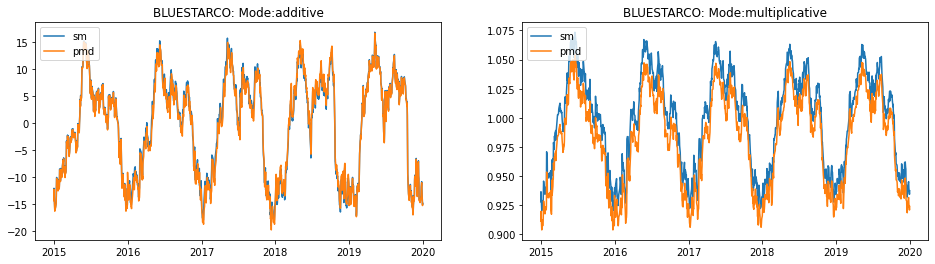

In [69]:
#Plot the Seasonal decompose output:
columns = len(sd_modes)
rows = cnt_stocks
fig, axes = plt.subplots(rows, columns, squeeze=False, #sharey='row',
                             figsize=(16, 4*rows) )
plt.title('Seasonal decompose output');

for stk in range(cnt_stocks):
    for m in range(columns):
        sp = axes[stk][m]
        key = f'_{sd_modes[m][0:3]}'            
        sp.plot(sd_pred_data.filter(regex=key, axis=1))            
        sp.legend(sd_algos, loc='upper left')
        sp.set_title(f"{stock_tickers[stk]}: Mode:{sd_modes[m]}")

plt.show()

In [70]:
#Get yearwise min. price
sd_pred_agg = sd_pred_data.groupby(group_by_col).idxmin().dropna().apply(get_wd, axis = 1)
sd_pred_agg

,sm_add,pmd_add,sm_mul,pmd_mul
year,,,,
2015,4.0,4.0,4.0,4.0
2016,14.0,15.0,12.0,13.0
2017,235.0,236.0,5.0,6.0
2018,218.0,218.0,240.0,240.0
2019,27.0,27.0,235.0,235.0


In [71]:
#Get avg. seasonality for last 5 years w/o ignoring the outlier to show the diff. betn. with and w/o outliers
sd_pred_agg.mean()

sm_add      99.6
pmd_add    100.0
sm_mul      99.2
pmd_mul     99.6
dtype: float64

In [72]:
#Get avg. seasonality for last 5 years while ignoring the outlier years
sd_pred_ref = pd.DataFrame(index = [current_year], columns = sd_pred_agg.columns)
df = sd_pred_agg.copy()
#1.25 is the average ratio of error to deviation for marking outliers
outlier_ratio = 1.25
#print(df.mean(), df.std(), df.sub(df.mean()).div(df.std()).abs())
#Doesn't matter even if some values are dropped in case of lower std below 5
ref_df = df * df.sub(df.mean()).div(df.std()).abs().lt(outlier_ratio)     
   
#Replace 0 with NaN to ensure that outliers are ignored while calculating mean
ref_df.replace(0, np.nan, inplace=True)
#print(ref_df)
#print(ref_df.mean())
sd_pred_ref.loc[current_year] = round(ref_df.mean(), 0)

#Rename column to indicate the correct interpretation
sd_pred_ref.index.name = 'pred_year'
sd_pred_ref

,sm_add,pmd_add,sm_mul,pmd_mul
pred_year,,,,
2020,100,100,99,100


##### Using HWES

In [73]:
pred_data = pred_dates.copy()

y_train = data[agg_value_col]
train_years = len(y_train.index.year.unique())
freq = int(round((len(y_train) / train_years), 0))

In [74]:
for mode in hwes_modes:
    for trend in hwes_trends:
        #Excluding extreme scenario when both trend and seasonality are multiplicative
        if (mode != 'multiplicative' or trend != 'multiplicative' ):
            hwes_model = HWES(y_train, seasonal_periods=freq, trend=trend, seasonal=mode).fit()            
            #print(hwes_model.summary())
            hwes_forecast = hwes_model.forecast(steps=len(pred_data))
            #print(hwes_forecast)
            if trend is None:
                 t = 'n'
            else:
                 t = trend[0]
            pred_data.loc[pred_data.index, 
                          f'hwes_t{t}_s{mode[0]}'] = pd.Series(hwes_forecast.values, index = pred_data.index) 
        #Use break to stop execution after 1 loop for debugging
        #break
    #break
        
pred_data

,ds,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm
work_doy,,,,,,
1,2020-01-01,826.624900,827.533941,828.814228,820.849924,820.898852
2,2020-01-02,826.355779,828.780559,830.664908,819.825058,819.901634
3,2020-01-03,828.229829,831.627580,834.518874,824.311458,824.405980
4,2020-01-06,826.286634,830.237647,834.309773,819.781269,819.878752
5,2020-01-07,824.180604,828.948765,833.841627,816.407138,816.513378
...,...,...,...,...,...,...
246,2020-12-24,824.823735,1020.358051,1403.124673,820.728372,838.108837
247,2020-12-28,824.701077,1021.035676,1405.962236,822.062092,839.439083
248,2020-12-29,824.355389,1021.143249,1408.238839,822.641707,840.020829


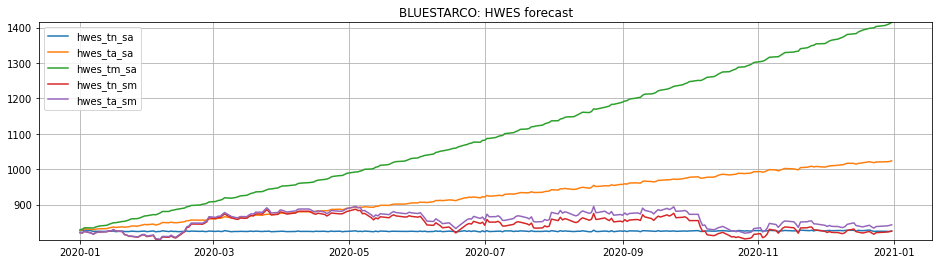

In [75]:
#Plot the HWES forecast output:
columns = 1
rows = 1
fig, axes = plt.subplots(rows, columns, squeeze=False, #sharey='row',
                             figsize=(16, 4*rows) )
plt.title('HWES forecast output')

#Drop unwated columns from plot = year
hwes_plot = pred_data.drop(['ds'], axis = 1)

splt = axes[0][0]                    
splt.plot(pred_data['ds'], hwes_plot) 
splt.grid(True)
#Set ylimit for better visualization
splt.set_ylim(hwes_plot.min().min(), min(data[agg_value_col].max() * 2, hwes_plot.max().max()))
splt.legend(hwes_plot.columns, loc='best')
splt.set_title(f"{stock_tickers[stk]}: HWES forecast")

plt.show()

##### Using AutoArima

In [76]:
ff_data.tail()

,year,month,week,day_of_week,day_of_month,day_of_year,FOURIER_S240-0,FOURIER_C240-0,FOURIER_S240-1,FOURIER_C240-1,FOURIER_S240-2,FOURIER_C240-2,FOURIER_S240-3,FOURIER_C240-3
4311,2019,12,52,1,24,358,-0.207909,0.978148,-0.406731,0.913548,-0.587778,0.809023,-0.743136,0.669140
4312,2019,12,52,3,26,360,-0.182232,0.983255,-0.358362,0.933583,-0.522491,0.852645,-0.669121,0.743153
4313,2019,12,52,4,27,361,-0.156431,0.987689,-0.309011,0.951058,-0.453982,0.891011,-0.587775,0.809024
4314,2019,12,53,0,30,364,-0.130523,0.991445,-0.258813,0.965927,-0.382675,0.923883,-0.499989,0.866032
4315,2019,12,53,1,31,365,-0.104525,0.994522,-0.207906,0.978149,-0.309008,0.951059,-0.406725,0.913551


In [77]:
#date_features = ["year","month","week","day_of_week","day_of_month","day_of_year"]
future_algo = 'hwes_tn_sa' #Any of the other algorithm outputs as exogenous input for ARIMAX
exog_data = pred_dates.copy()
#exog_data.reset_index(inplace = True) #Uncomment if work day is required
exog_data.set_index('ds', inplace = True)
exog_data['year'] = exog_data.index.year
exog_data["month"] = exog_data.index.month
exog_data['week'] = pd.Int64Index(exog_data.index.isocalendar().week) #Deprecated - rawdf.index.week/weekofyear
exog_data["day_of_week"] = exog_data.index.dayofweek
exog_data["day_of_month"] = exog_data.index.day
exog_data['day_of_year'] = exog_data.index.dayofyear
#Handle ISO week format for last days of year marked as Week 1
exog_data.loc[(exog_data['week'] == 1) & (exog_data['day_of_year'] > 350),'week'] = 53 
#print(exog_data)

#FourierFeaturizer
trans = pm.preprocessing.FourierFeaturizer(m=frequency, k=4) #k = no. of Sin/Cos terms - columns = k*2
y_future, future_ff_data = trans.fit_transform(pred_data[future_algo], exogenous=exog_data[date_features])

future_ff_data

,year,month,week,day_of_week,day_of_month,day_of_year,FOURIER_S240-0,FOURIER_C240-0,FOURIER_S240-1,FOURIER_C240-1,FOURIER_S240-2,FOURIER_C240-2,FOURIER_S240-3,FOURIER_C240-3
0,2020,1,1,2,1,1,0.026177,0.999657,0.052336,0.998630,0.078459,0.996917,0.104528,0.994522
1,2020,1,1,3,2,2,0.052336,0.998630,0.104528,0.994522,0.156434,0.987688,0.207912,0.978148
2,2020,1,1,4,3,3,0.078459,0.996917,0.156434,0.987688,0.233445,0.972370,0.309017,0.951057
3,2020,1,2,0,6,6,0.104528,0.994522,0.207912,0.978148,0.309017,0.951057,0.406737,0.913545
4,2020,1,2,1,7,7,0.130526,0.991445,0.258819,0.965926,0.382683,0.923880,0.500000,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2020,12,52,3,24,359,0.156435,0.987688,0.309017,0.951056,0.453991,0.891006,0.587786,0.809017
246,2020,12,53,0,28,363,0.182236,0.983255,0.358368,0.933580,0.522499,0.852640,0.669131,0.743144
247,2020,12,53,1,29,364,0.207912,0.978148,0.406737,0.913545,0.587786,0.809017,0.743145,0.669130
248,2020,12,53,2,30,365,0.233446,0.972370,0.453991,0.891006,0.649448,0.760406,0.809017,0.587785


In [78]:
train_exog = None
test_exog = None
for mode in pmd_modes:
    if (mode == pmd_modes[0]):
        train_exog = ff_data.drop(date_features, axis=1)#Drop other exogenous features if, added
        test_exog = future_ff_data.drop(date_features, axis=1)#Drop other exogenous features if, added
    else:
        train_exog = ff_data.copy()
        test_exog = future_ff_data.copy()

    #forecasting
    aa_model = pm.auto_arima(y_train, exogenous=train_exog, d=n_diffs, max_p=6, 
                     seasonal=False, stepwise=True, suppress_warnings=True, trace=False)
    #print('AutoArima Model order:', aa_model.order)
    #print(aa_model.summary())
    aa_fcast, conf_int = aa_model.predict(n_periods=len(pred_data), exogenous=test_exog, return_conf_int=True)
    #aa_fcast = aa_model.predict(n_periods=len(pred_data), exogenous=test_exog, return_conf_int=False)
    #print(aa_fcast)
    pred_data.loc[pred_data.index, f'aa_{mode}'] = pd.Series(aa_fcast, index = pred_data.index) 
#Use break to stop execution after 1 loop for debugging        
#break

pred_data

,ds,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date
work_doy,,,,,,,,
1,2020-01-01,826.624900,827.533941,828.814228,820.849924,820.898852,828.434456,831.249889
2,2020-01-02,826.355779,828.780559,830.664908,819.825058,819.901634,828.402027,831.669224
3,2020-01-03,828.229829,831.627580,834.518874,824.311458,824.405980,828.040926,831.046469
4,2020-01-06,826.286634,830.237647,834.309773,819.781269,819.878752,828.810571,831.634624
5,2020-01-07,824.180604,828.948765,833.841627,816.407138,816.513378,828.886320,832.161263
...,...,...,...,...,...,...,...,...
246,2020-12-24,824.823735,1020.358051,1403.124673,820.728372,838.108837,874.539160,886.983839
247,2020-12-28,824.701077,1021.035676,1405.962236,822.062092,839.439083,874.693421,887.330726
248,2020-12-29,824.355389,1021.143249,1408.238839,822.641707,840.020829,874.853430,887.573472


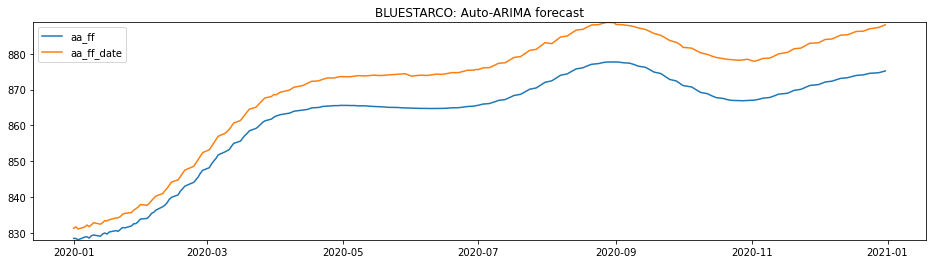

In [79]:
#Plot the Auto-ARIMA forecast output:
columns = 1
rows = 1
fig, axes = plt.subplots(rows, columns, squeeze=False, #sharey='row',
                             figsize=(16, 4*rows) )
plt.title('Auto-ARIMA with FourierFeaturizer forecast output')

#Drop unwated columns from plot = year
aa_plot = pred_data.filter(regex = '^aa_', axis = 1) #regex filter for aa

splt = axes[0][0]                    
splt.plot(pred_data['ds'], aa_plot) 
#Set ylimit for better visualization
splt.set_ylim(aa_plot.min().min(), min(data[agg_value_col].max() * 2, aa_plot.max().max()))
splt.legend(aa_plot.columns, loc='best')
splt.set_title(f"{stock_tickers[stk]}: Auto-ARIMA forecast")

plt.show()

##### Using FB Prophet

In [80]:
pred_dates_cap = pred_dates.copy()
#Required for growth = "logistic"
pred_dates_cap['cap'] = 1.5 * pdata.y.max() #Capping the price growth at 50% of max. value

pdata.head(), pred_dates_cap.head()

(          ds         y        cap
 0 2002-07-01  3.985216  1279.6138
 1 2002-07-02  3.964178  1279.6138
 2 2002-07-03  4.024287  1279.6138
 3 2002-07-04  4.042319  1279.6138
 4 2002-07-05  4.039313  1279.6138,
                  ds        cap
 work_doy                      
 1        2020-01-01  1279.6138
 2        2020-01-02  1279.6138
 3        2020-01-03  1279.6138
 4        2020-01-06  1279.6138
 5        2020-01-07  1279.6138)

In [81]:
for mode in fb_smodes:
    for trend in fb_growth:
        t = trend[0:3]
        m = 's' + mode[0:1]
        fb_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, growth=trend, seasonality_mode=mode)
        fb_model.fit(pdata)
        fb_fcast = fb_model.predict(pred_dates_cap)
        pred_data.loc[pred_data.index, f'fb_yhat_{t}_{m}'] = pd.Series(fb_fcast.yhat.values, index = pred_data.index) 
        pred_data.loc[pred_data.index, f'fb_yearly_{t}_{m}'] = pd.Series(fb_fcast.yearly.values, index = pred_data.index) 
        
        #Use break to stop execution after 1 loop for debugging
        #break
    #break        
pred_data

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date,fb_yhat_lin_sa,fb_yearly_lin_sa,fb_yhat_log_sa,fb_yearly_log_sa,fb_yhat_lin_sm,fb_yearly_lin_sm,fb_yhat_log_sm,fb_yearly_log_sm
work_doy,,,,,,,,,,,,,,,,
1,2020-01-01,826.624900,827.533941,828.814228,820.849924,820.898852,828.434456,831.249889,781.746129,-1.675333,797.230456,-1.704146,780.075696,-0.003282,790.692446,-0.007816
2,2020-01-02,826.355779,828.780559,830.664908,819.825058,819.901634,828.402027,831.669224,782.131042,-1.520748,797.785448,-1.398206,780.500413,-0.003032,791.448967,-0.007174
3,2020-01-03,828.229829,831.627580,834.518874,824.311458,824.405980,828.040926,831.046469,782.512550,-1.369567,798.336010,-1.096645,780.908537,-0.002803,792.184402,-0.006559
4,2020-01-06,826.286634,830.237647,834.309773,819.781269,819.878752,828.810571,831.634624,783.566440,-1.006660,799.871321,-0.308029,781.849572,-0.002479,794.035276,-0.005160
5,2020-01-07,824.180604,828.948765,833.841627,816.407138,816.513378,828.886320,832.161263,783.863692,-0.939736,800.314221,-0.113923,782.007155,-0.002570,794.458043,-0.004937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2020-12-24,824.823735,1020.358051,1403.124673,820.728372,838.108837,874.539160,886.983839,863.482900,-2.395809,880.940222,-3.382234,861.371407,-0.004019,871.751933,-0.011080
247,2020-12-28,824.701077,1021.035676,1405.962236,822.062092,839.439083,874.693421,887.330726,864.673615,-2.126404,882.598259,-2.630518,862.312455,-0.003988,873.796899,-0.009770
248,2020-12-29,824.355389,1021.143249,1408.238839,822.641707,840.020829,874.853430,887.573472,865.027639,-2.002708,883.089631,-2.365546,862.694355,-0.003811,874.504443,-0.009220


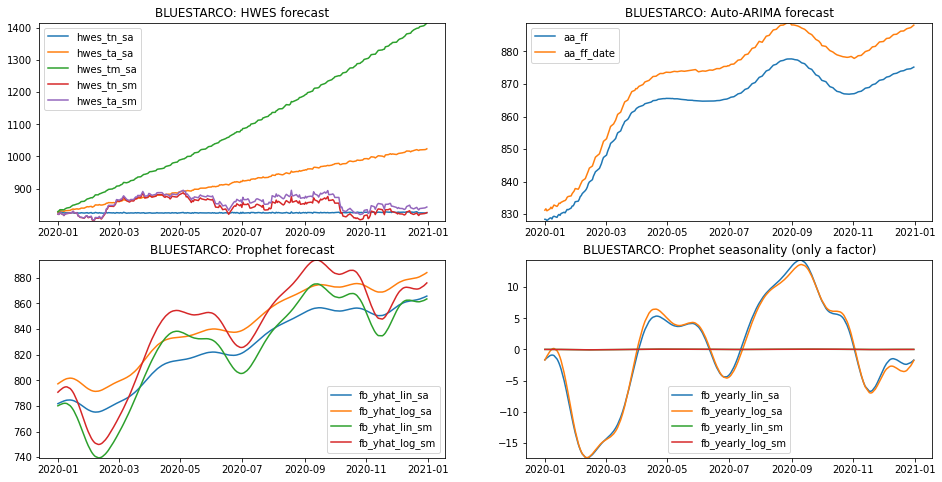

In [82]:
#Plot the forecast output:
columns = 2
rows = 2
fig, axes = plt.subplots(rows, columns, squeeze=False, #sharey='row',
                             figsize=(16, 4*rows) )
plt.title(f"{stock_tickers[stk]}: Time series forecast output")

splt = axes[0][0]     
hwes_plot = pred_data.filter(regex = '^hwes_', axis = 1) #regex filter for hwes
splt.plot(pred_data['ds'], hwes_plot)
splt.set_ylim(hwes_plot.min().min(), min(data[agg_value_col].max() * 2, hwes_plot.max().max()))
splt.legend(hwes_plot.columns, loc='best')
splt.set_title(f"{stock_tickers[stk]}: HWES forecast")

splt = axes[0][1]    
aa_plot = pred_data.filter(regex = '^aa_', axis = 1)#regex filter for autoarima
splt.plot(pred_data['ds'], aa_plot) 
splt.set_ylim(aa_plot.min().min(), min(data[agg_value_col].max() * 2, aa_plot.max().max()))
splt.legend(aa_plot.columns, loc='best')
splt.set_title(f"{stock_tickers[stk]}: Auto-ARIMA forecast")

splt = axes[1][0]     
fb_plot = pred_data.filter(regex = '^fb_yhat_', axis = 1) #regex filter for fb prediction
splt.plot(pred_data['ds'], fb_plot)
splt.set_ylim(fb_plot.min().min(), min(data[agg_value_col].max() * 2, fb_plot.max().max()))
splt.legend(fb_plot.columns, loc='best')
splt.set_title(f"{stock_tickers[stk]}: Prophet forecast")

splt = axes[1][1]    
fb_yr_plot = pred_data.filter(regex = '^fb_yearly_', axis = 1)#regex filter for fb seasonality
splt.plot(pred_data['ds'], fb_yr_plot) 
splt.set_ylim(fb_yr_plot.min().min(), min(data[agg_value_col].max() * 2, fb_yr_plot.max().max()))
splt.legend(fb_yr_plot.columns, loc='best')
splt.set_title(f"{stock_tickers[stk]}: Prophet seasonality (only a factor)")

plt.show()

In [83]:
ts_pred_ref = pred_data.groupby(pred_data.ds.dt.year).idxmin()
ts_pred_ref

,ds,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date,fb_yhat_lin_sa,fb_yearly_lin_sa,fb_yhat_log_sa,fb_yearly_log_sa,fb_yhat_lin_sm,fb_yearly_lin_sm,fb_yhat_log_sm,fb_yearly_log_sm
ds,,,,,,,,,,,,,,,,
2020,1,121,1,1,27,27,3,3,28,31,28,31,30,31,29,30


In [84]:
min_wd_pred = sd_pred_ref.transpose().append(ts_pred_ref.transpose()[1:])
min_wd_pred.columns = ['pred_wd_min']
min_wd_pred

,pred_wd_min
sm_add,100
pmd_add,100
sm_mul,99
pmd_mul,100
hwes_tn_sa,121
hwes_ta_sa,1
hwes_tm_sa,1
hwes_tn_sm,27
hwes_ta_sm,27
aa_ff,3


In [85]:
#If there are more than 2 entries for both first month and last month, normalize the data
date_range = 30
if ((min_wd_pred.pred_wd_min < date_range).sum() > 2) & ((min_wd_pred.pred_wd_min > (len(pred_dates) - date_range)).sum() > 2):
    min_wd_pred.loc[min_wd_pred.pred_wd_min < date_range, 'pred_wd_min'] = min_wd_pred.pred_wd_min + len(pred_dates)
min_wd_pred

,pred_wd_min
sm_add,100
pmd_add,100
sm_mul,99
pmd_mul,100
hwes_tn_sa,121
hwes_ta_sa,1
hwes_tm_sa,1
hwes_tn_sm,27
hwes_ta_sm,27
aa_ff,3


In [86]:
df = min_wd_pred.copy()
retry = 0
while ((df.max()[0] - df.min()[0] > date_range) & (retry < 3)) : 
    retry = retry + 1
    #print(retry)
    #print(df.mean(), df.std(), df.sub(df.mean()).div(df.std()).abs())
    outlier_ratio = retry #1.25
    df = df * df.sub(df.mean()).div(df.std()).abs().lt(outlier_ratio)     
    #print(df)
    #Remove outliers indicated by 0 
    df = df[df.pred_wd_min > 0]
    #print(df)
    continue
        
output_range = df.sort_values(by='pred_wd_min')
output_range

,pred_wd_min
hwes_tn_sm,27
hwes_ta_sm,27
fb_yhat_lin_sa,28
fb_yhat_log_sa,28
fb_yhat_log_sm,29
fb_yhat_lin_sm,30
fb_yearly_log_sm,30
fb_yearly_lin_sa,31
fb_yearly_log_sa,31
fb_yearly_lin_sm,31


In [87]:
if (output_range.max()[0] - output_range.min()[0] > 30) :
    print('Seasonality not indicated by stock')
else: 
    to_date = int(output_range.max()[0])       
    if int(output_range.max()[0]) > len(pred_dates):
        to_date = to_date - len(pred_dates)
    print('Predicted Working day range for stock to have min. value =', 
      int(output_range.min()[0]), 'to', to_date, 'with median at', output_range.median()[0])

Predicted Working day range for stock to have min. value = 27 to 31 with median at 29.5


Notes:
<ol>
    <li>Since data is going to be widely different for each stock, we need to do anlysis and model fitting separately for each stock</li>
    <li>Since this is going to be an yearly exercise, or at best a monthly exercise, we will have to re-run this exercise every cycle with latest data</li>
    <li>I have used 5 techniques and about 4 basic variations of each of them</li>
    <li>Compare the avg. and best price prediction accuracy of last 5 years for all the above variations</li>
    <li>Select the top 5 models below 15 days absolute error i.e. 30 days time frame</li>
    <li>Use the top 5 models for next year's best invesment day prediction</li> 
    <li>Get the average, with yearly round off for values close to start and end of year. For avg. above 365 subtract 365</li>
</ol>

Remember: 
    SMAPE = 2 * (actual - pred) / (actual + pred)
    
SMAPE is not a good accuracy metric for our scenario will be larger for values near to start of year as compare to values at end of year with the same value of absolute diff. in predicted and actual values.